#### TITLE OF PROJECT:  Generating Counterfactual Ecxplanation for German Credit Data with Deep Learning Models

#### Preparing the Tools

In [ ]:
# Importing Libraries and Frameworks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

# Setting seed For reproducibility
seed = 42
np.random.seed(seed)



from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from collections import Counter




from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,ParameterSampler
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, precision_recall_curve,roc_auc_score,classification_report, average_precision_score)
from sklearn.inspection import permutation_importance

import shap
import alibi
import dice_ml

#### Data

The data used in this research is the German Credit Data which is a publicly available dataset downloaded from https://www.kaggle.com/datasets/uciml/german-credit

#### Importing the Dataset

In [ ]:
german_data = pd.read_csv('german_data.csv')

In [ ]:
german_data

Creditability  Account Balance  Duration of Credit (month)  \
0                1                1                          18   
1                1                1                           9   
2                1                2                          12   
3                1                1                          12   
4                1                1                          12   
..             ...              ...                         ...   
995              0                1                          24   
996              0                1                          24   
997              0                4                          21   
998              0                2                          12   
999              0                1                          30   

     Payment Status of Previous Credit  Purpose  Credit Amount  \
0                                    4        2           1049   
1                                    4        0           2799   
2                                    2        9            841   
3                                    4        0           2122   
4                                    4        0           2171   
..                                 ...      ...            ...   
995                                  2        3           1987   
996                                  2        0           2303   
997                                  4        0          12680   
998                                  2        3           6468   
999                                  2        2           6350   

     Value Savings/Stocks  Length of current employment  Instalment per cent  \
0                       1                             2                    4   
1                       1                             3                    2   
2                       2                             4                    2   
3                       1                             3                    3   
4                       1                             3                    4   
..                    ...                           ...                  ...   
995                     1                             3                    2   
996                     1                             5                    4   
997                     5                             5                    4   
998                     5                             1                    2   
999                     5                             5                    4   

     Sex & Marital Status  ...  Duration in Current address  \
0                       2  ...                            4   
1                       3  ...                            2   
2                       2  ...                            4   
3                       3  ...                            2   
4                       3  ...                            4   
..                    ...  ...                          ...   
995                     3  ...                            4   
996                     3  ...                            1   
997                     3  ...                            4   
998                     3  ...                            1   
999                     3  ...                            4   

     Most valuable available asset  Age (years)  Concurrent Credits  \
0                                2           21                   3   
1                                1           36                   3   
2                                1           23                   3   
3                                1           39                   3   
4                                2           38                   1   
..                             ...          ...                 ...   
995                              1           21                   3   
996                              1           45                   3   
997                              4           30   

### Exploratory Data Analysis

In [ ]:
# Checking for missing values in each column
missing_values = german_data.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
Creditability                        0
Account Balance                      0
Duration of Credit (month)           0
Payment Status of Previous Credit    0
Purpose                              0
Credit Amount                        0
Value Savings/Stocks                 0
Length of current employment         0
Instalment per cent                  0
Sex & Marital Status                 0
Guarantors                           0
Duration in Current address          0
Most valuable available asset        0
Age (years)                          0
Concurrent Credits                   0
Type of apartment                    0
No of Credits at this Bank           0
Occupation                           0
No of dependents                     0
Telephone                            0
Foreign Worker                       0
dtype: int64


In [ ]:
# To get summary statistics for data numeric features
summary_stats = german_data.describe()
print("Summary Statistics:")
print(summary_stats)


Summary Statistics:
       Creditability  Account Balance  Duration of Credit (month)  \
count    1000.000000      1000.000000                 1000.000000   
mean        0.700000         2.577000                   20.903000   
std         0.458487         1.257638                   12.058814   
min         0.000000         1.000000                    4.000000   
25%         0.000000         1.000000                   12.000000   
50%         1.000000         2.000000                   18.000000   
75%         1.000000         4.000000                   24.000000   
max         1.000000         4.000000                   72.000000   

       Payment Status of Previous Credit      Purpose  Credit Amount  \
count                         1000.00000  1000.000000     1000.00000   
mean                             2.54500     2.828000     3271.24800   
std                              1.08312     2.744439     2822.75176   
min                              0.00000     0.000000      250.00000  

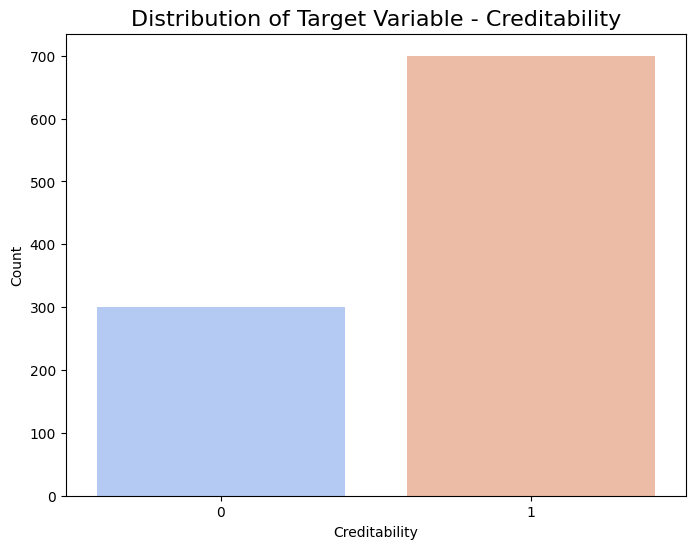

In [ ]:
#To glimpse at the distribution of the Creditability column (Target Variable)

plt.figure(figsize=(8, 6))
sns.countplot(x='Creditability', data=german_data, palette='coolwarm')
plt.title("Distribution of Target Variable - Creditability", fontsize=16)
plt.xlabel("Creditability")
plt.ylabel("Count");


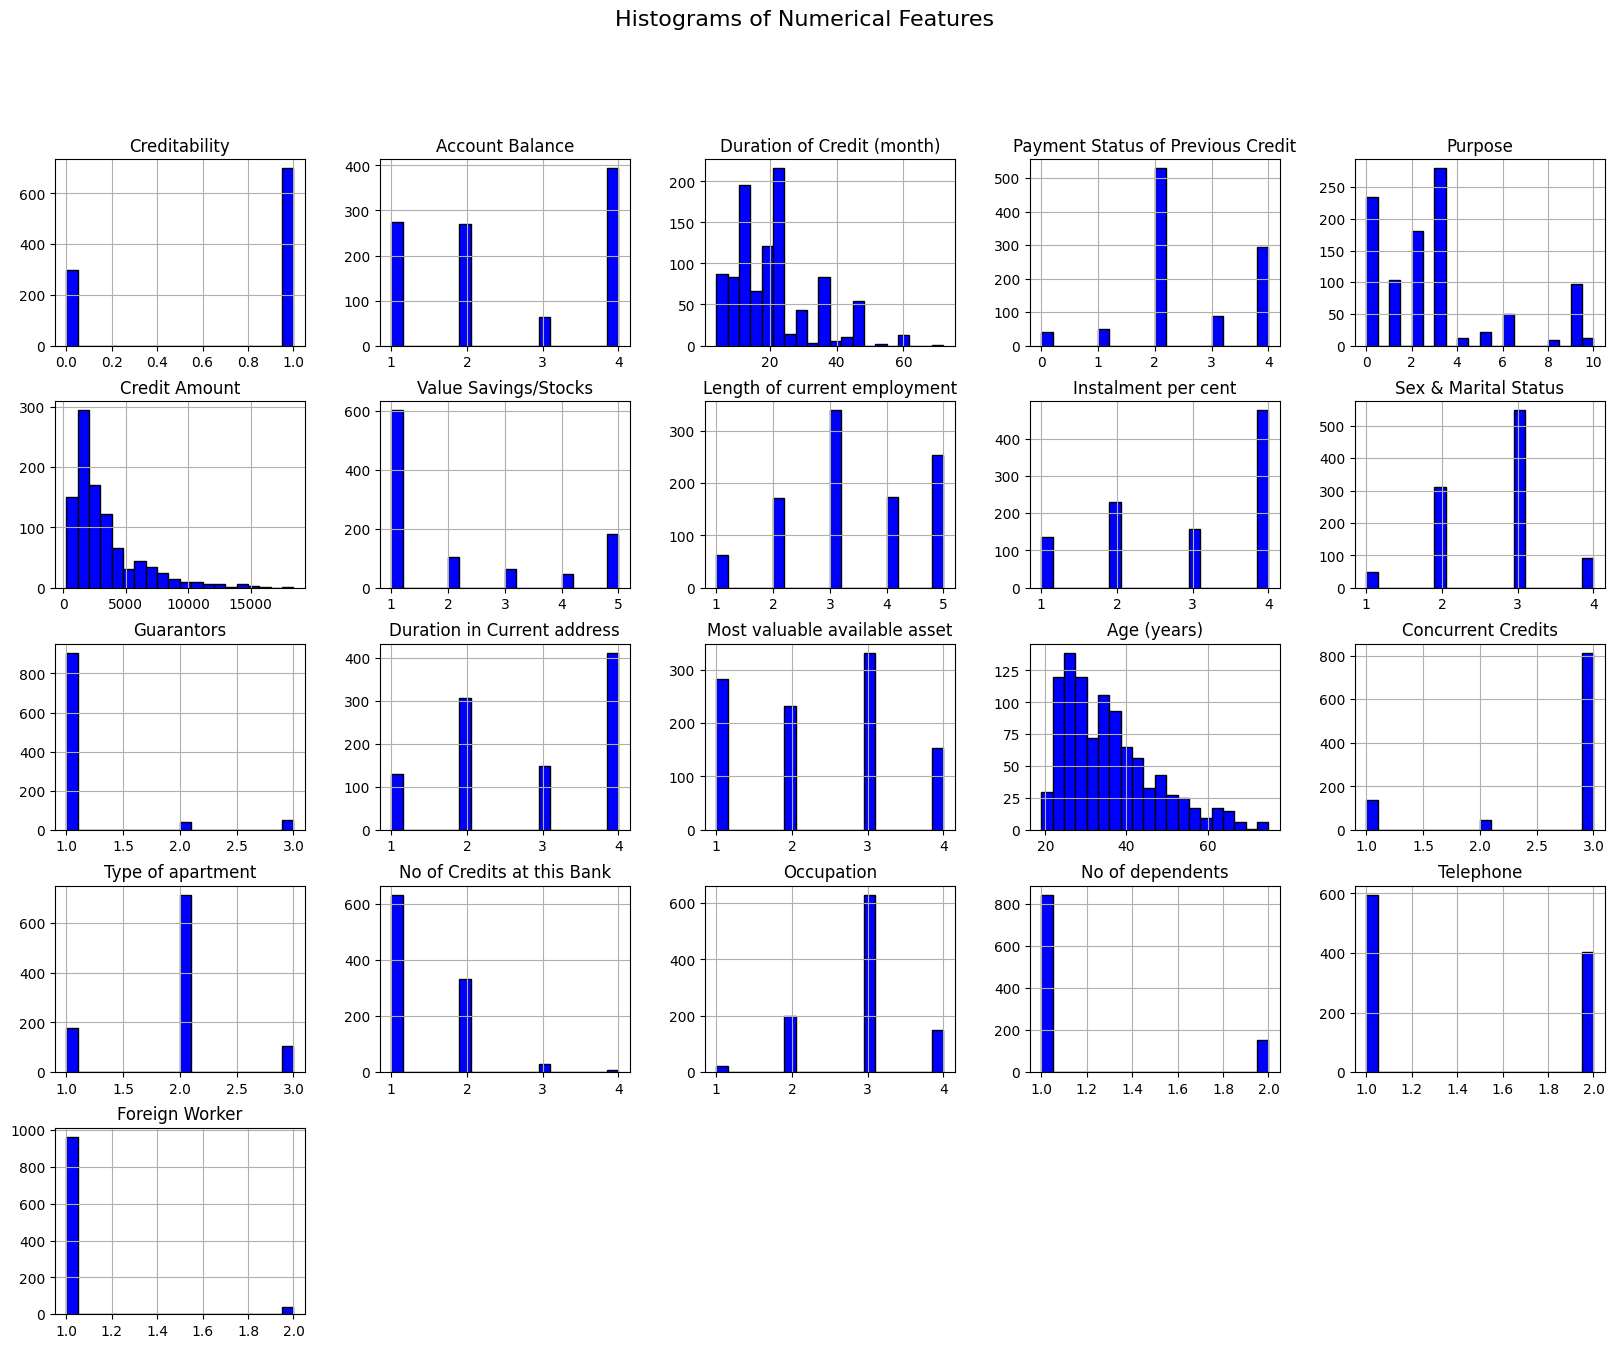

In [ ]:
# Histograms for each numerical feature in the dataset
german_data.hist(figsize=(20, 15), bins=20, color='blue', edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16);

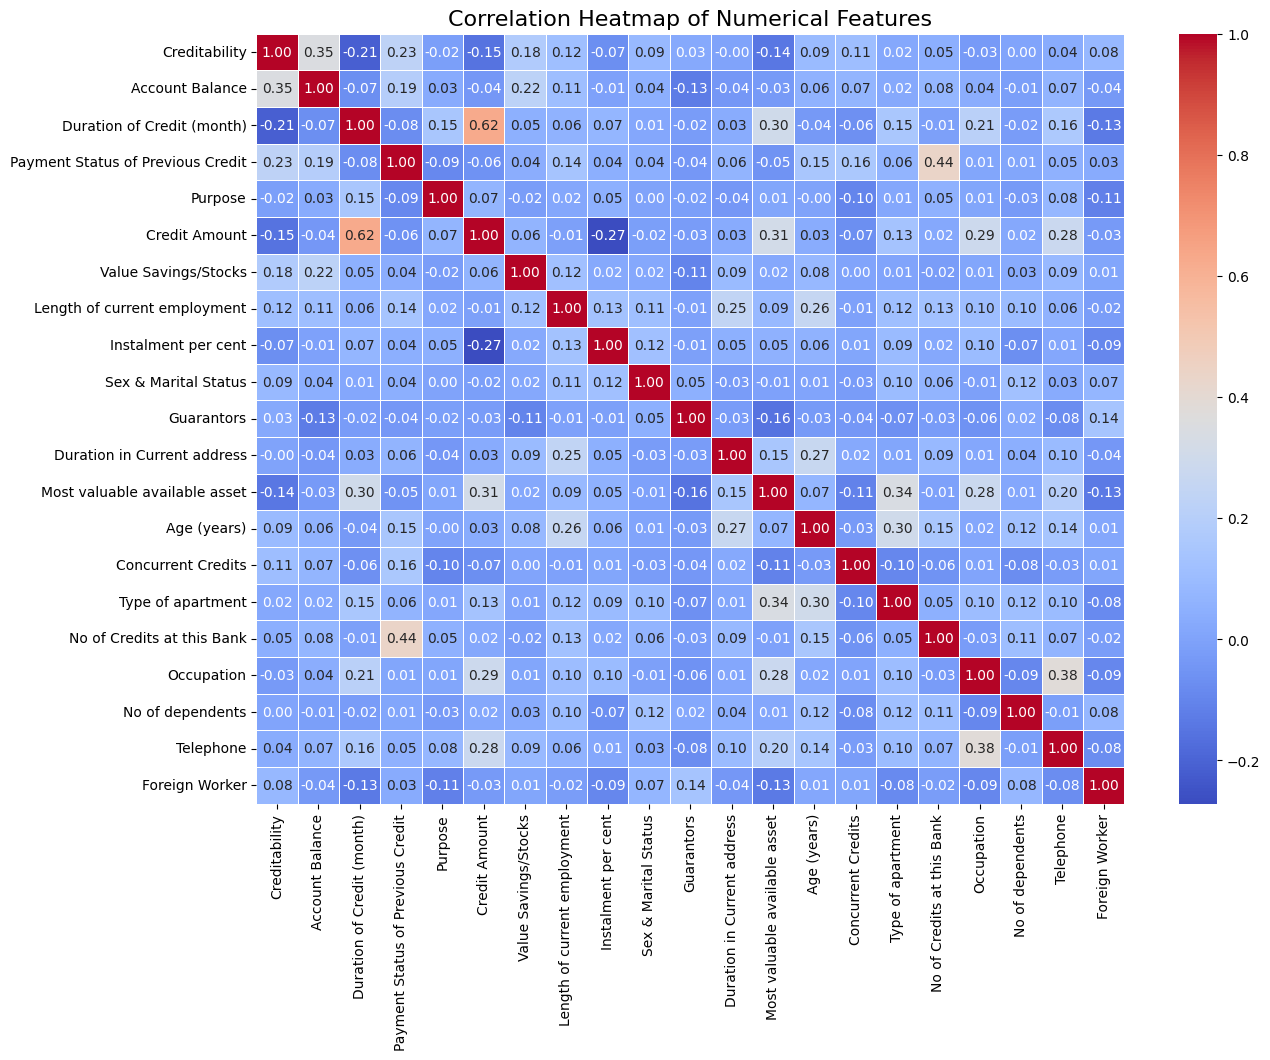

In [ ]:
# A Heatmap Showcasingbthe Correlation matric of the data
plt.figure(figsize=(14, 10))
corr = german_data.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16);

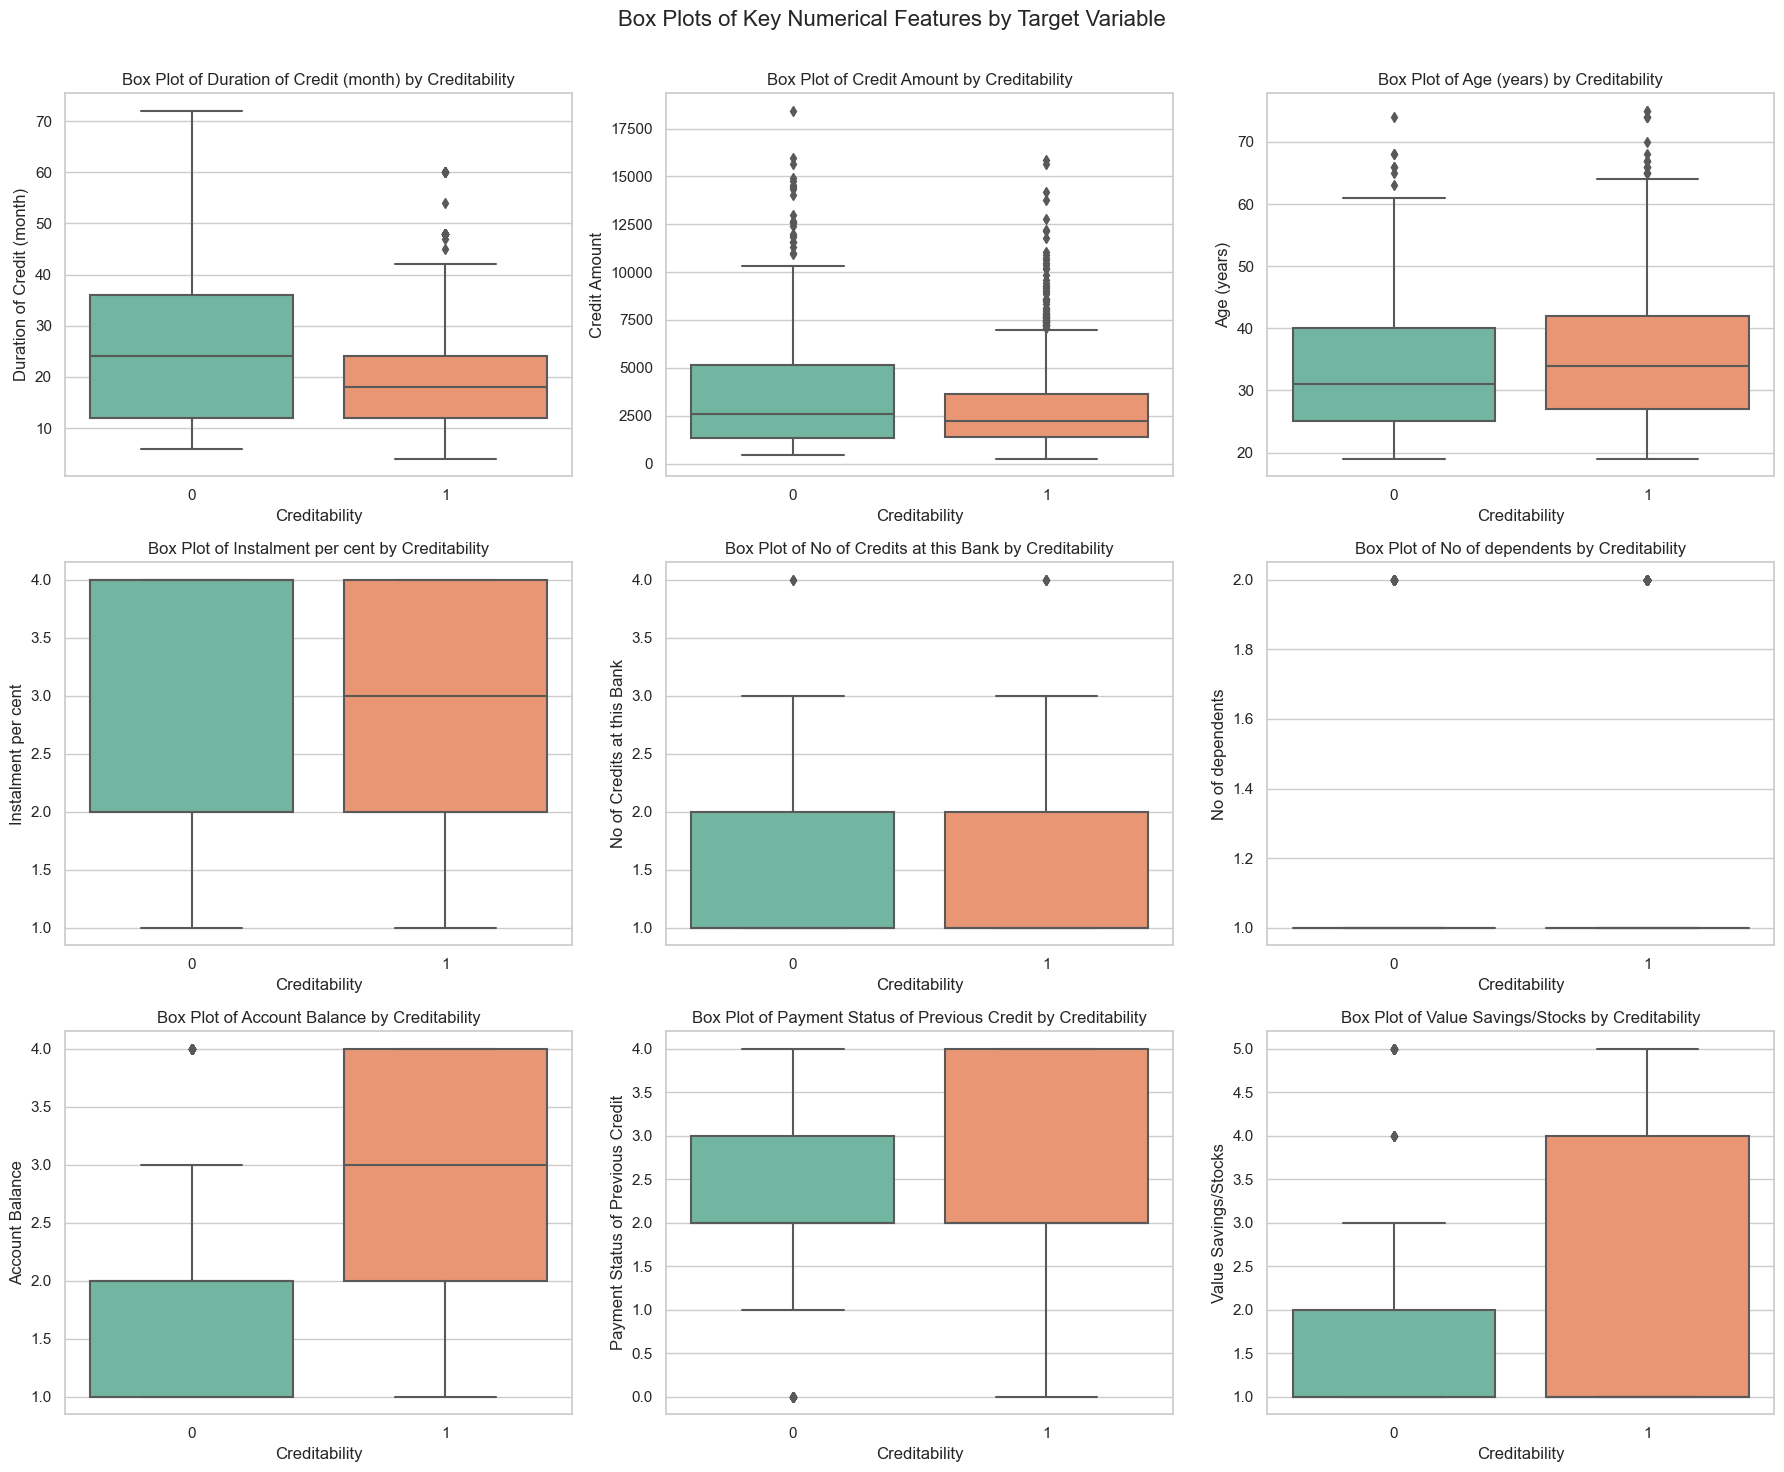

In [ ]:
# Boxplot to Understand Distribution and Outliers

# Seaborn Style for the grid
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
numerical_cols = [
    "Duration of Credit (month)",
    "Credit Amount",
    "Age (years)",
    "Instalment per cent",
    "No of Credits at this Bank",
    "No of dependents",
    "Account Balance",
    "Payment Status of Previous Credit",
    "Value Savings/Stocks",
]
for i, col in enumerate(numerical_cols):
    sns.boxplot(ax=axes[i // 3, i % 3], data=german_data, x="Creditability", y=col, palette="Set2")
    axes[i // 3, i % 3].set_title(f"Box Plot of {col} by Creditability")

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Box Plots of Key Numerical Features by Target Variable", fontsize=16);

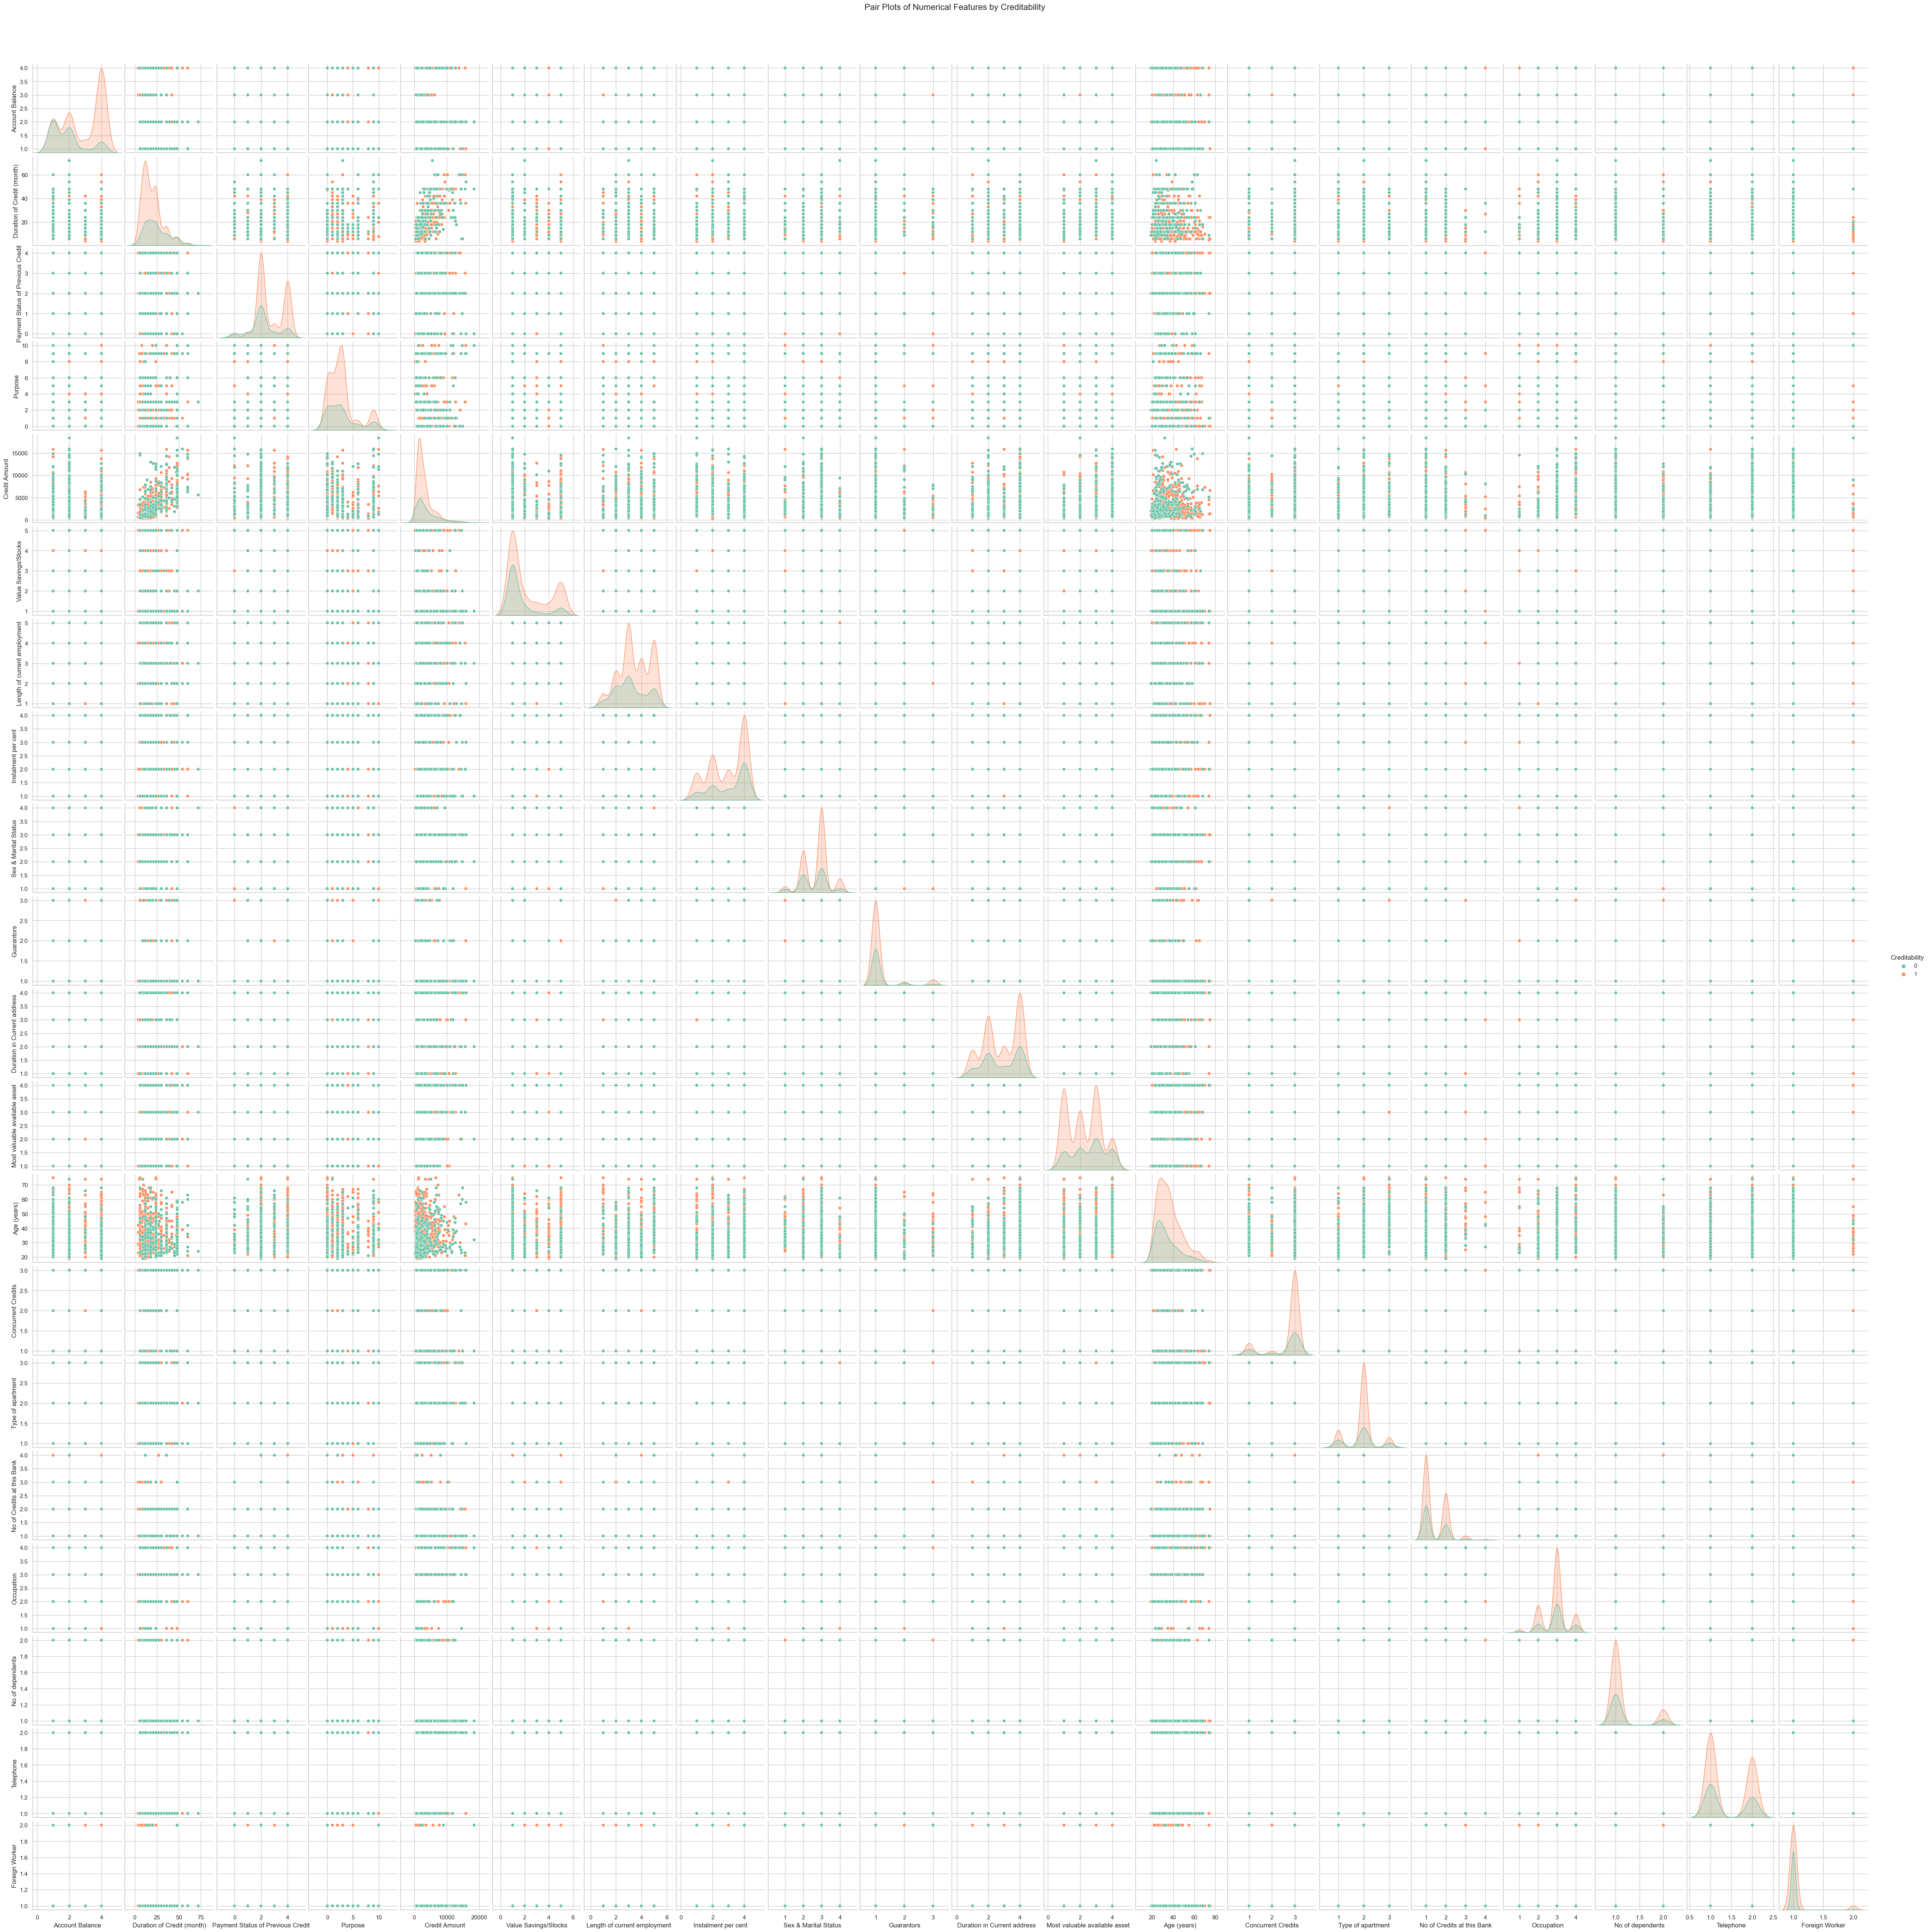

In [ ]:
# Pair plots to visualize pairwise relationships and the separability by Creditability
sns.pairplot(german_data, hue="Creditability", palette="Set2")
plt.suptitle("Pair Plots of Numerical Features by Creditability", y=1.02, fontsize=16);

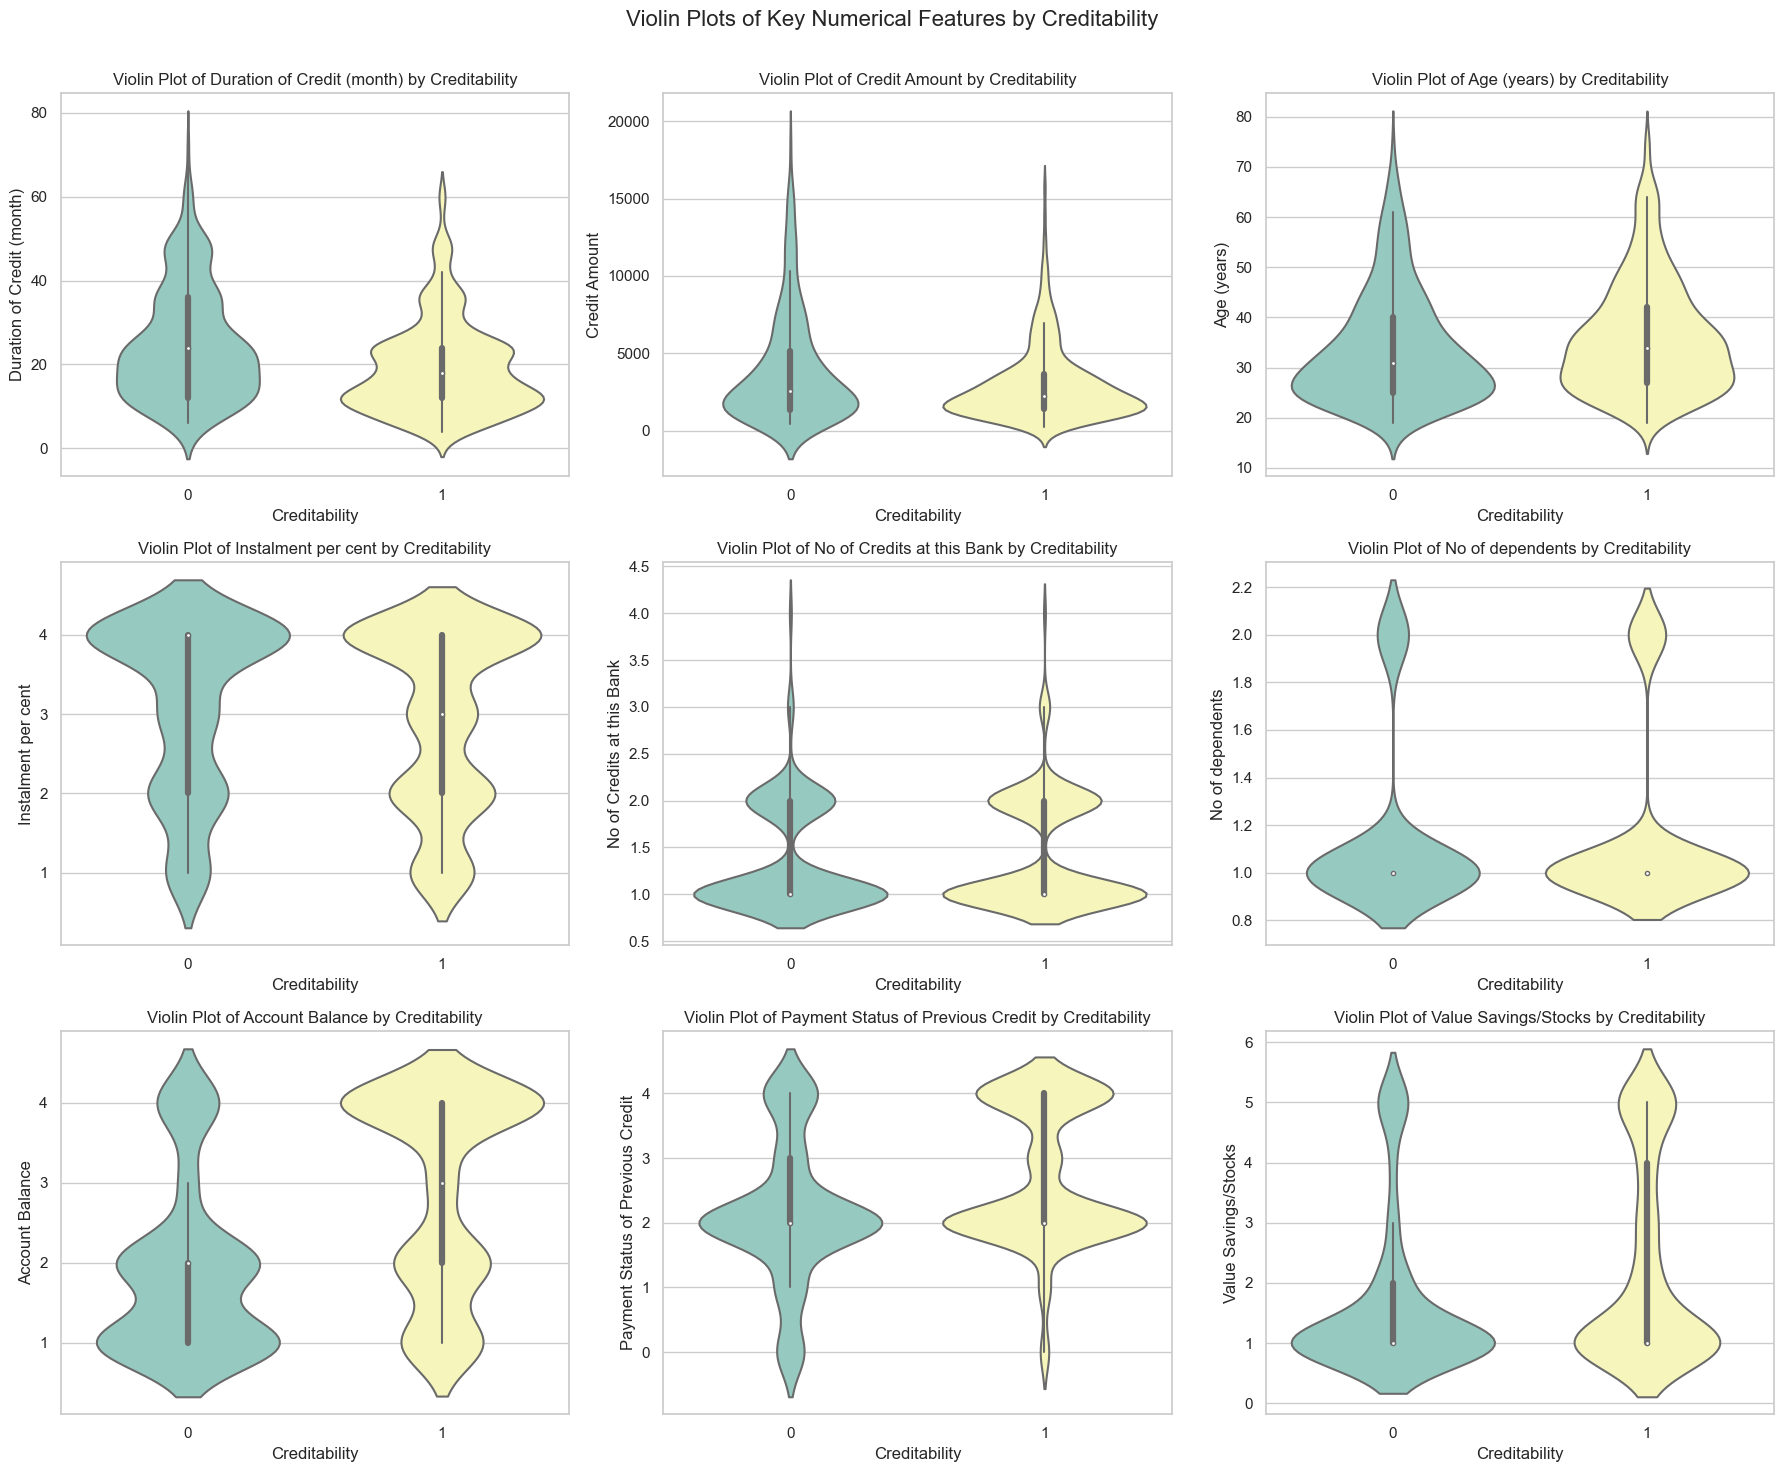

In [ ]:
# Violin plots -- Shows the distribution of the data across features by the Target Variable
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
for i, col in enumerate(numerical_cols):
    sns.violinplot(ax=axes[i // 3, i % 3], data=german_data, x="Creditability", y=col, palette="Set3")
    axes[i // 3, i % 3].set_title(f"Violin Plot of {col} by Creditability")

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Violin Plots of Key Numerical Features by Creditability", fontsize=16);

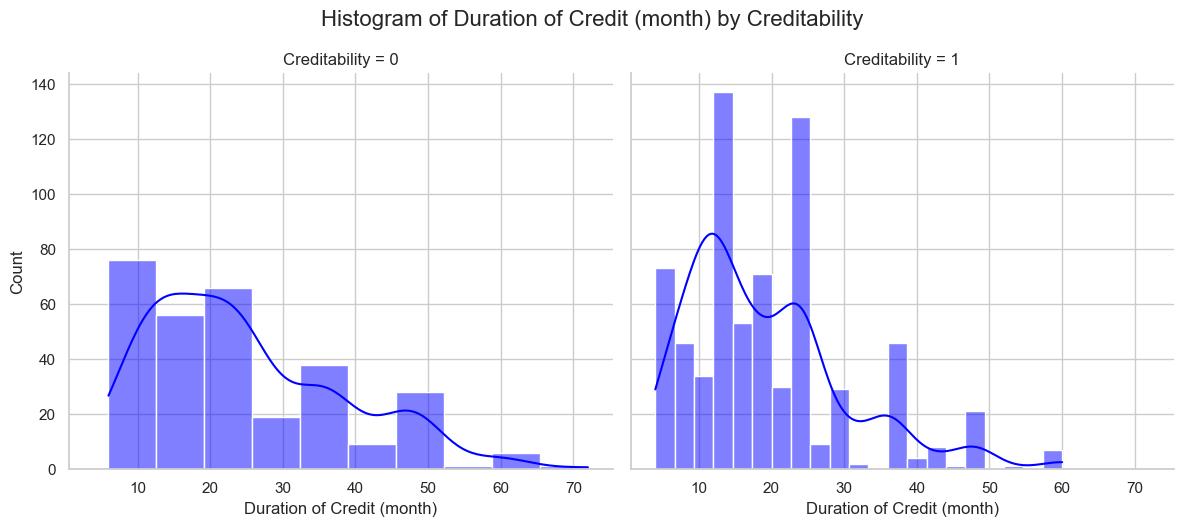

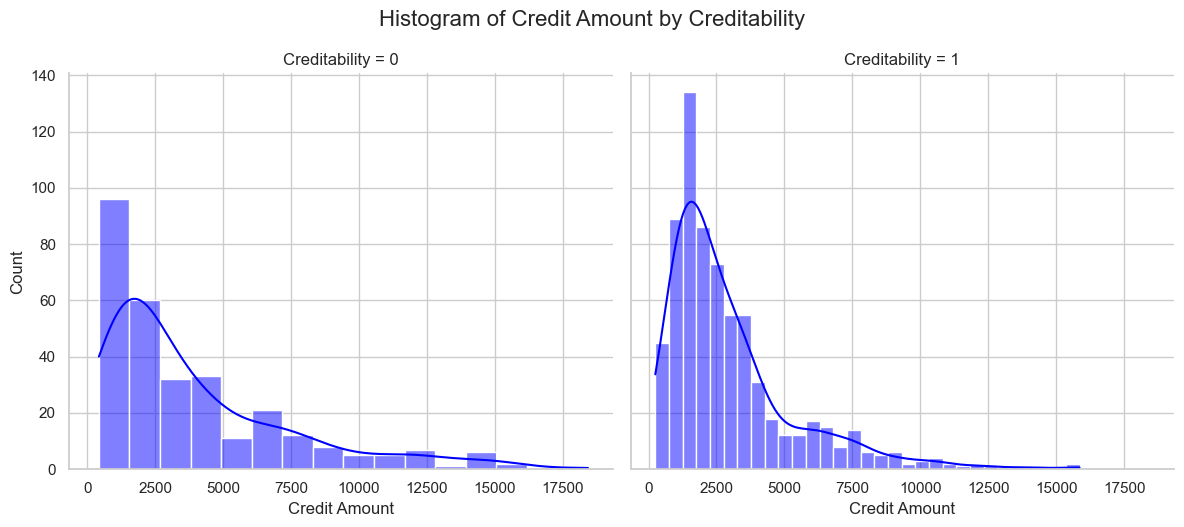

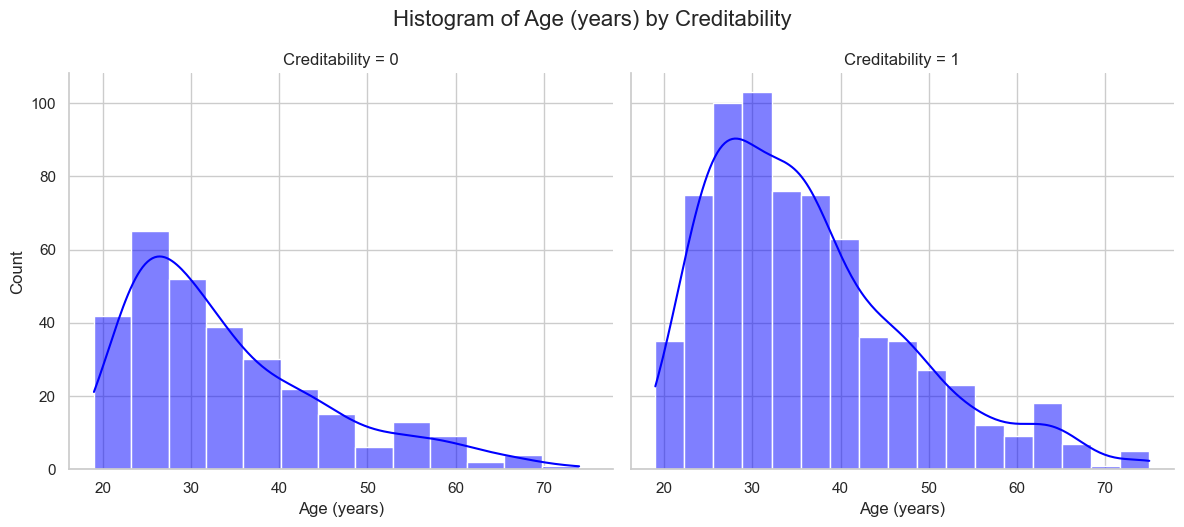

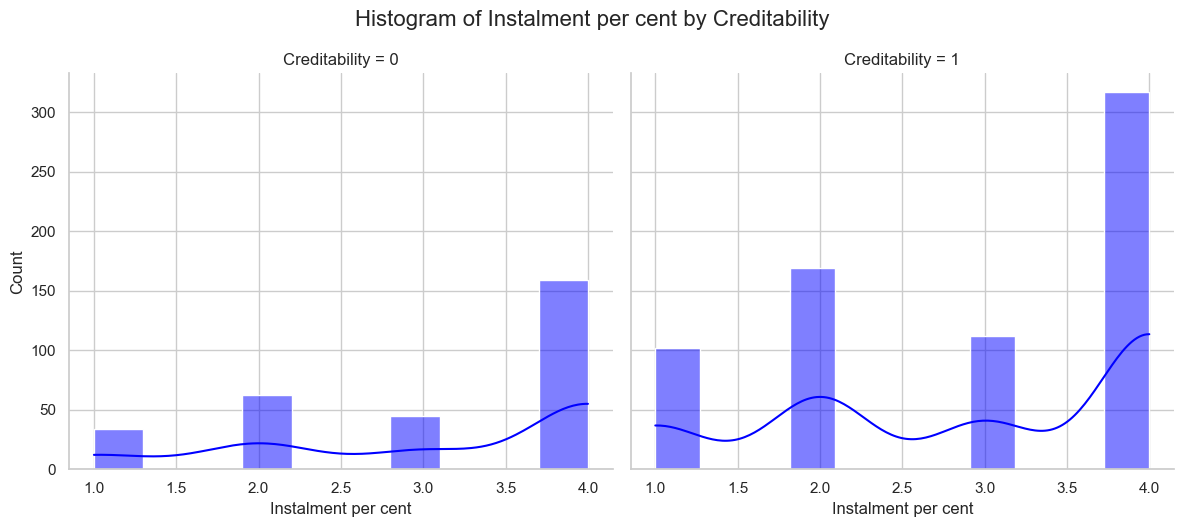

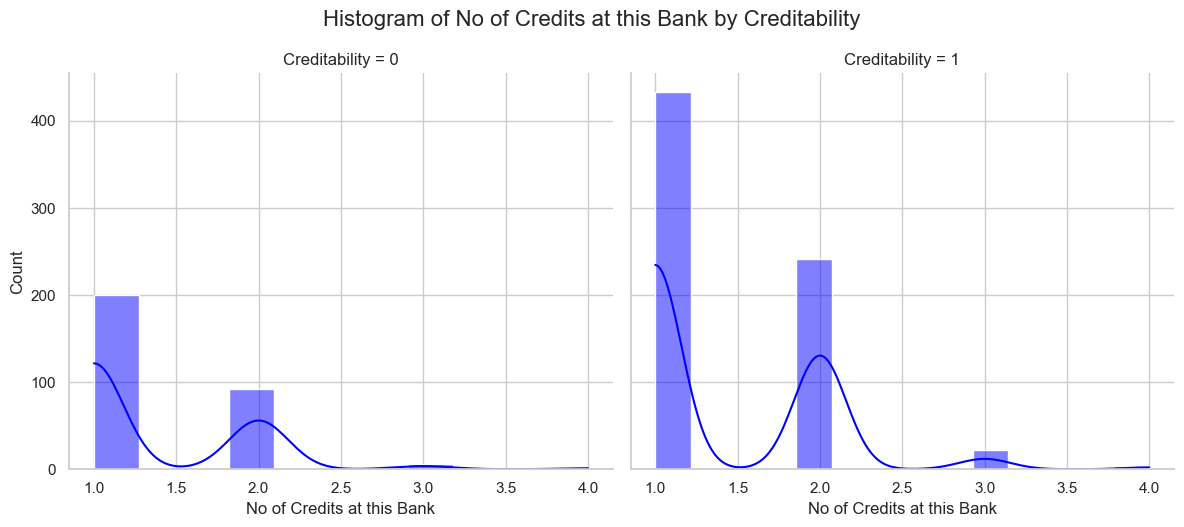

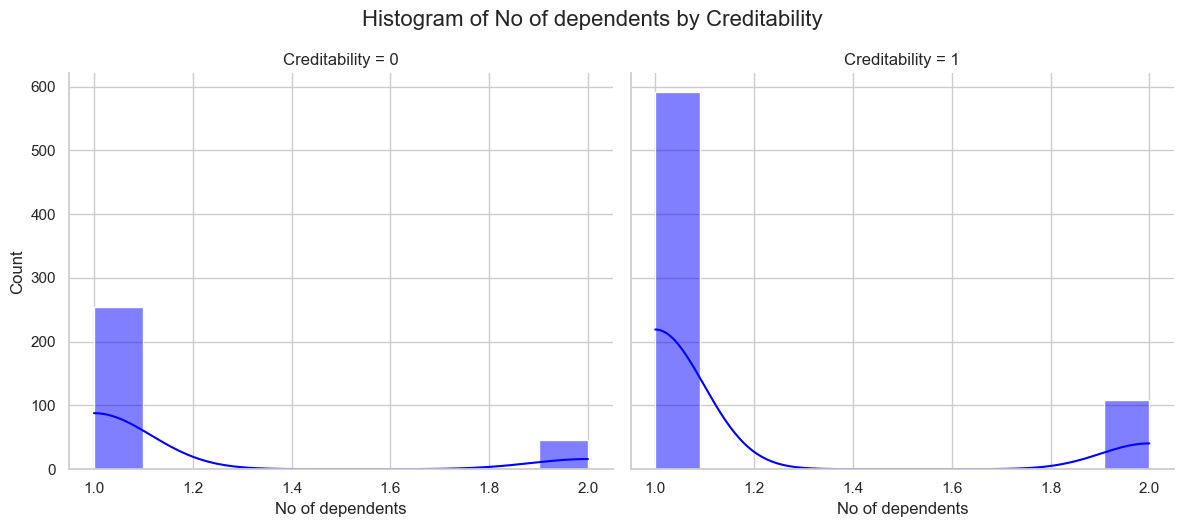

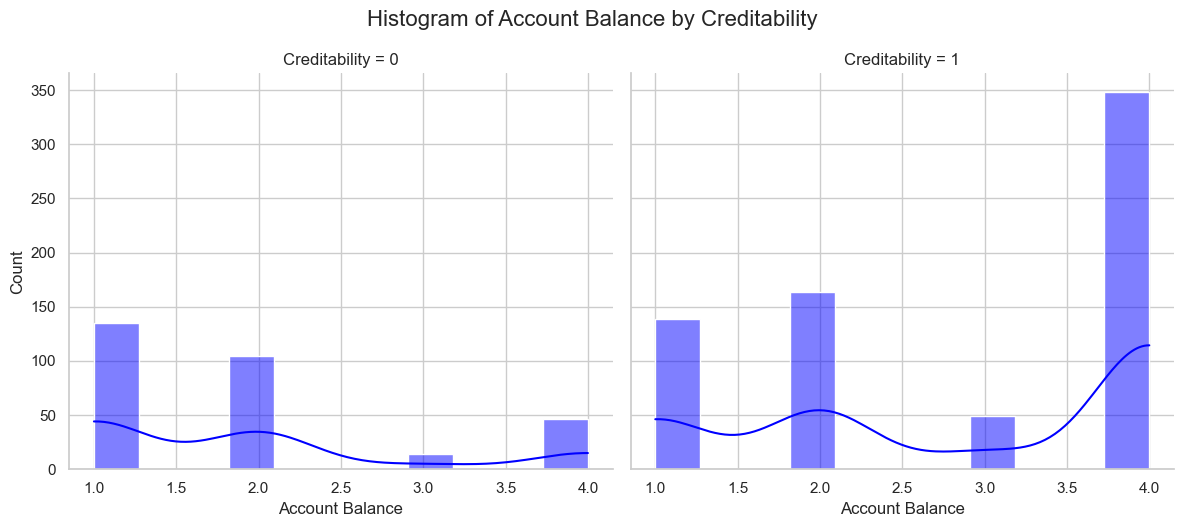

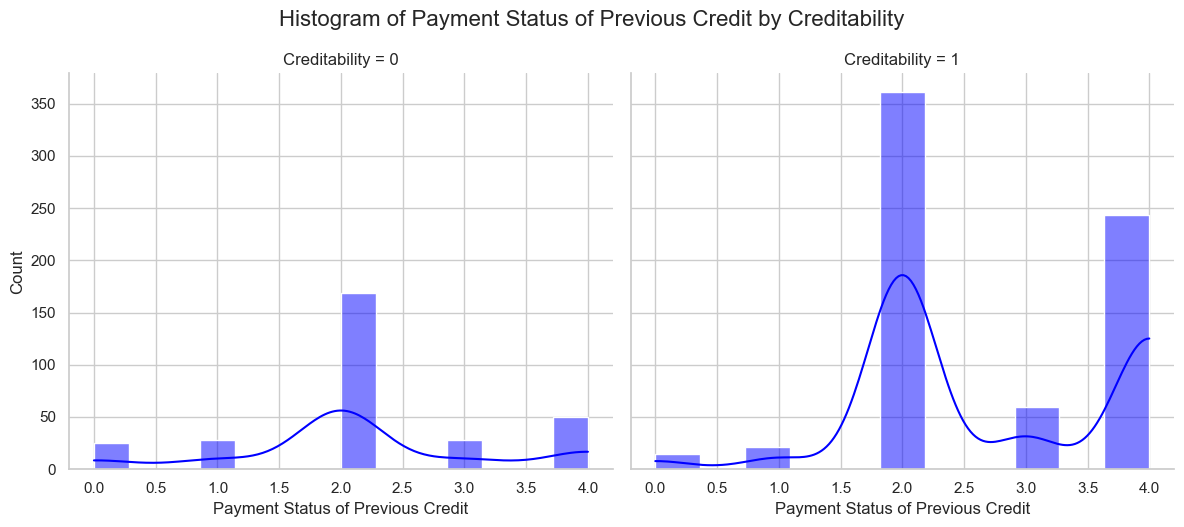

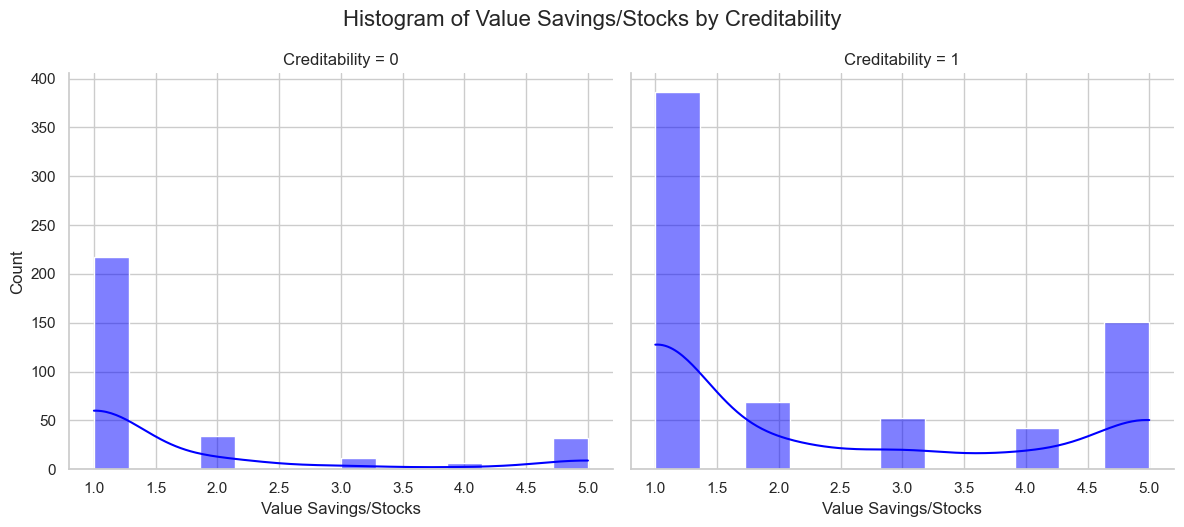

In [ ]:
# Facet Grid histograms for key feature by Creditability
facet_cols = [
    "Duration of Credit (month)", "Credit Amount", "Age (years)",
    "Instalment per cent", "No of Credits at this Bank", "No of dependents",
    "Account Balance", "Payment Status of Previous Credit", "Value Savings/Stocks"
]

for col in facet_cols:
    g = sns.FacetGrid(german_data, col="Creditability", margin_titles=True, height=5, aspect=1.2)
    g.map_dataframe(sns.histplot, x=col, kde=True, color="blue")
    g.fig.suptitle(f"Histogram of {col} by Creditability", fontsize=16, y=1.05);


## Preprocessing

### Feature Engineering

##### Encoding and Feature Scaling

In [ ]:
data = german_data

# Defining categorical and numerical features based on the dataset scenario
categorical_features = [
    'Account Balance', 'Payment Status of Previous Credit', 'Purpose', 'Value Savings/Stocks',
    'Length of current employment', 'Instalment per cent', 'Sex & Marital Status', 'Guarantors',
    'Duration in Current address', 'Most valuable available asset', 'Concurrent Credits',
    'Type of apartment', 'No of Credits at this Bank', 'Occupation', 'No of dependents',
    'Telephone', 'Foreign Worker'
]
numerical_features = ['Duration of Credit (month)', 'Credit Amount', 'Age (years)']



In [ ]:
# To create transformers for categorical and numerical data separately
categorical_transformer = OneHotEncoder()
numeric_transformer = StandardScaler()

# To create the ColumnTransformer to apply the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Applying the preprocessing to the features, not including the target variable 'Creditability'
X_transformed = preprocessor.fit_transform(data.drop('Creditability', axis=1))




In [ ]:
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
print("Encoded Feature Names:", encoded_feature_names)



Encoded Feature Names: ['Account Balance_1' 'Account Balance_2' 'Account Balance_3'
 'Account Balance_4' 'Payment Status of Previous Credit_0'
 'Payment Status of Previous Credit_1'
 'Payment Status of Previous Credit_2'
 'Payment Status of Previous Credit_3'
 'Payment Status of Previous Credit_4' 'Purpose_0' 'Purpose_1' 'Purpose_2'
 'Purpose_3' 'Purpose_4' 'Purpose_5' 'Purpose_6' 'Purpose_8' 'Purpose_9'
 'Purpose_10' 'Value Savings/Stocks_1' 'Value Savings/Stocks_2'
 'Value Savings/Stocks_3' 'Value Savings/Stocks_4'
 'Value Savings/Stocks_5' 'Length of current employment_1'
 'Length of current employment_2' 'Length of current employment_3'
 'Length of current employment_4' 'Length of current employment_5'
 'Instalment per cent_1' 'Instalment per cent_2' 'Instalment per cent_3'
 'Instalment per cent_4' 'Sex & Marital Status_1' 'Sex & Marital Status_2'
 'Sex & Marital Status_3' 'Sex & Marital Status_4' 'Guarantors_1'
 'Guarantors_2' 'Guarantors_3' 'Duration in Current address_1'
 'Durat

In [ ]:
print("Shape of Transformed Data:", X_transformed.shape)

Shape of Transformed Data: (1000, 71)


#### Data Splitting

In [ ]:
y = data['Creditability'].values

In [ ]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((800, 71), (200, 71), (800,), (200,))

### MODEL 1. MULTILAYER PERCEPTRON

In [ ]:
# converting the sparse matrix into dense format
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()


In [ ]:
# Build a simple MLP model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
# To compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_dense, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
23/23 [==============================] - 2s 41ms/step - loss: 0.5938 - accuracy: 0.6889 - val_loss: 0.5089 - val_accuracy: 0.7500
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5355 - accuracy: 0.7125 - val_loss: 0.4822 - val_accuracy: 0.7625
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.4988 - accuracy: 0.7278 - val_loss: 0.4656 - val_accuracy: 0.7375
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.4674 - accuracy: 0.7792 - val_loss: 0.4704 - val_accuracy: 0.7875
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 0.4435 - accuracy: 0.7931 - val_loss: 0.4525 - val_accuracy: 0.7250
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.4248 - accuracy: 0.8125 - val_loss: 0.4678 - val_accuracy: 0.8000
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.4064 - accuracy: 0.8236 - val_loss: 0.4552 - val_accuracy: 0.7500
Epoch 8/50
23/23 [=

In [ ]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

7/7 [==============================] - 0s 3ms/step - loss: 1.3929 - accuracy: 0.7550
Test Accuracy: 0.7549999952316284


In [ ]:
# Model Architecture with dropout and L2 regularization
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Introducing early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_dense, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/50
23/23 [==============================] - 1s 14ms/step - loss: 1.9026 - accuracy: 0.6028 - val_loss: 1.7081 - val_accuracy: 0.7500
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 1.6737 - accuracy: 0.6653 - val_loss: 1.5104 - val_accuracy: 0.7500
Epoch 3/50
23/23 [==============================] - 0s 5ms/step - loss: 1.4773 - accuracy: 0.7153 - val_loss: 1.3583 - val_accuracy: 0.7500
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 1.3496 - accuracy: 0.7014 - val_loss: 1.2248 - val_accuracy: 0.7500
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 1.2183 - accuracy: 0.7000 - val_loss: 1.1109 - val_accuracy: 0.7750
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 1.1185 - accuracy: 0.7222 - val_loss: 1.0187 - val_accuracy: 0.7875
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 1.0374 - accuracy: 0.7153 - val_loss: 0.9339 - val_accuracy: 0.8000
Epoch 8/50
23/23 [=

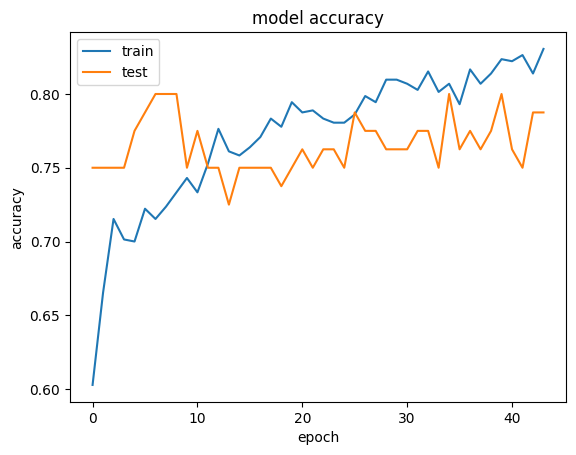

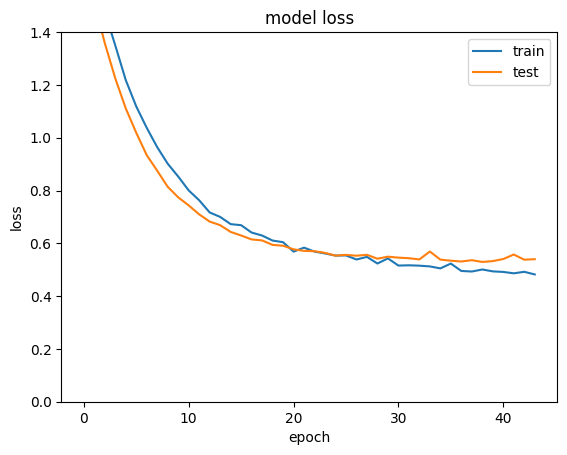

In [ ]:
# To summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.ylim([0,1])
# To summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim([0,1.4])
plt.show()

In [ ]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

7/7 [==============================] - 0s 5ms/step - loss: 0.6014 - accuracy: 0.7650
Test Accuracy: 0.7649999856948853


In [ ]:
#To compute performance metrics
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # This converts probabilities to 0 or 1

# To calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

7/7 [==============================] - 0s 3ms/step
Accuracy: 0.765
Precision: 0.7861635220125787
Recall: 0.9057971014492754
F1 Score: 0.8417508417508418
ROC AUC Score: 0.6787050023375409


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.45      0.54        62
           1       0.79      0.91      0.84       138

    accuracy                           0.77       200
   macro avg       0.73      0.68      0.69       200
weighted avg       0.75      0.77      0.75       200



In [ ]:
# Confution matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))


7/7 [==============================] - 0s 4ms/step
[[ 28  34]
 [ 13 125]]


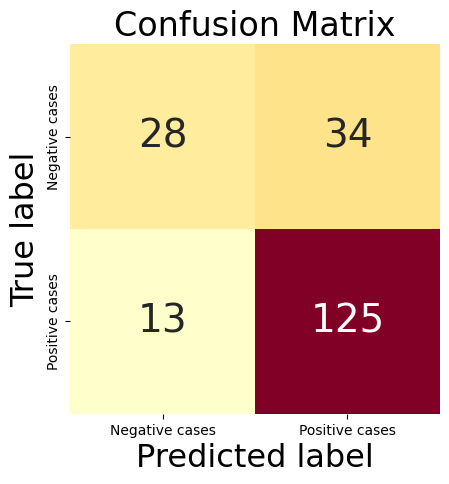

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative cases', 'Positive cases'],
            yticklabels=['Negative cases', 'Positive cases'],
            cmap='YlOrRd', annot_kws={"fontsize": 28})

plt.xlabel('Predicted label', fontsize=23)
plt.ylabel('True label', fontsize=23)
plt.title('Confusion Matrix', fontsize=24)

plt.show()

7/7 [==============================] - 0s 3ms/step


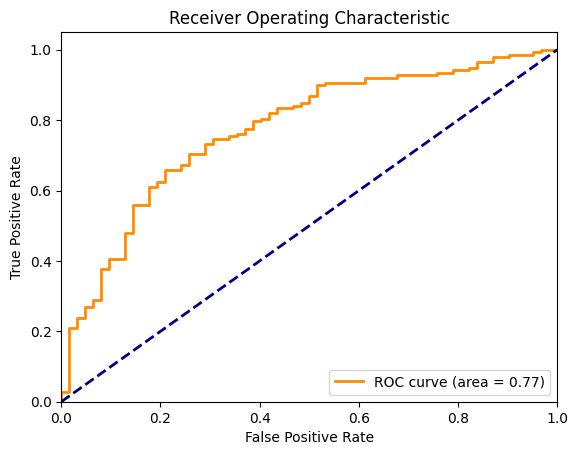

In [ ]:
#To plot the ROC Curve

# To Predict probabilities
y_pred_prob = model.predict(X_test)

# To Compute the ROC curve and ROC area for each of the classes
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

7/7 [==============================] - 0s 7ms/step
AUPRC1: 0.8710986295555386


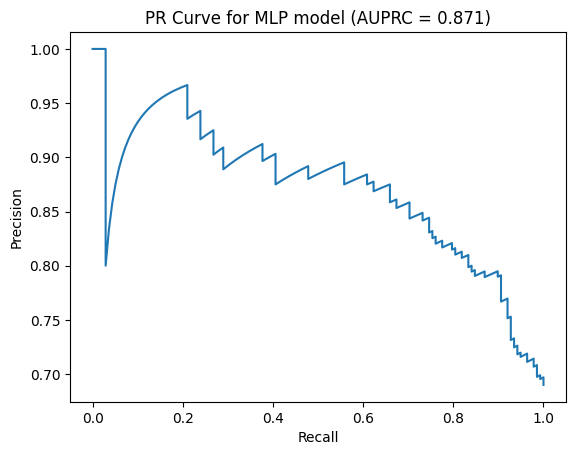

In [ ]:
# To determine the probabilities for positive class
y_scores = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# To calculate area under the PRC
auprc = average_precision_score(y_test, y_scores)
print('AUPRC1:', auprc)

# To Plot the PR curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for MLP model (AUPRC = {:.3f})'.format(auprc))
plt.show()

In [ ]:
# Creating a counterfactual explanation

In [ ]:

# Select an instance (index 0 for demonstration)
original_instance = X_test_dense[0]
original_instance = np.expand_dims(original_instance, axis=0)




In [ ]:
# Manually modify the credit amount
modified_instance = np.copy(original_instance)
credit_amount_index = 5  # Hypothetical index for Credit Amount in the feature set
modified_instance[0, credit_amount_index] += 3000  # Increase by $3000



In [ ]:
# Predict the outcomes for both instances
original_prediction = model.predict(original_instance)
modified_prediction = model.predict(modified_instance)



1/1 [==============================] - 0s 46ms/step


In [ ]:
print("Original Prediction:", original_prediction)
print("Modified Prediction:", modified_prediction)

Original Prediction: [[0.36544412]]
Modified Prediction: [[1.]]


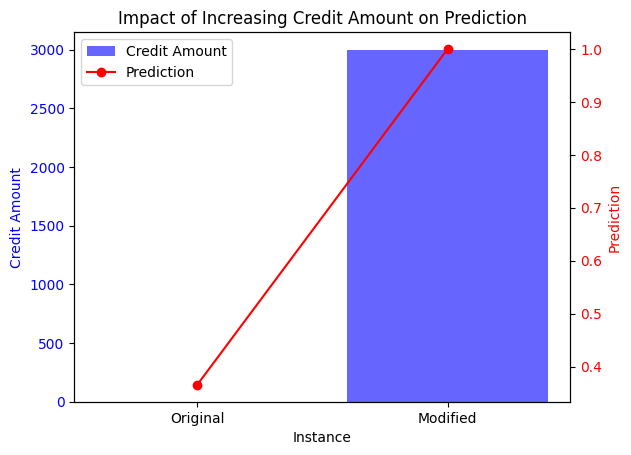

In [ ]:

# Defines the feature and its index
feature = 'Credit Amount'
index = 5  #  from dataset and pre-processing

# This gathers values for the visualization
original_value = original_instance[0, index]
modified_value = modified_instance[0, index]
original_pred = original_prediction[0][0]
modified_pred = modified_prediction[0][0]

# Setting up the plot
fig, ax1 = plt.subplots()

# Creates a bar chart for the feature values
features = ['Original', 'Modified']
values = [original_value, modified_value]
ax1.bar(features, values, color='b', alpha=0.6, label='Credit Amount')

ax1.set_xlabel('Instance')
ax1.set_ylabel('Credit Amount', color='b')
ax1.tick_params(axis='y', labelcolor='b')

#
ax2 = ax1.twinx()
predictions = [original_pred, modified_pred]
ax2.plot(features, predictions, color='r', marker='o', label='Prediction')
ax2.set_ylabel('Prediction', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Legend to the left
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

# To view the plot
plt.title('Impact of Increasing Credit Amount on Prediction')
plt.show()


In [ ]:
### MODEL 2 CNN

In [ ]:
# Reshaping  the preprocessed inputs for to fit in CNN archtecture
#Conv1D: (batch_size, steps, input_dim)

X_train = X_train.toarray().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.toarray().reshape(X_test.shape[0], X_test.shape[1], 1)





In [ ]:
# CNN Model architecture
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])



In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 69, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 34, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 16, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 50)               

In [ ]:
# To train the model

In [ ]:
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
25/25 [==============================] - 2s 32ms/step - loss: 0.6190 - accuracy: 0.6775 - val_loss: 0.6036 - val_accuracy: 0.6900
Epoch 2/30
25/25 [==============================] - 0s 10ms/step - loss: 0.5809 - accuracy: 0.7025 - val_loss: 0.5908 - val_accuracy: 0.6900
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.5597 - accuracy: 0.7113 - val_loss: 0.5496 - val_accuracy: 0.7000
Epoch 4/30
25/25 [==============================] - 0s 10ms/step - loss: 0.5174 - accuracy: 0.7400 - val_loss: 0.5288 - val_accuracy: 0.6900
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.5013 - accuracy: 0.7550 - val_loss: 0.5252 - val_accuracy: 0.7250
Epoch 6/30
25/25 [==============================] - 0s 11ms/step - loss: 0.4863 - accuracy: 0.7625 - val_loss: 0.5071 - val_accuracy: 0.7650
Epoch 7/30
25/25 [==============================] - 0s 9ms/step - loss: 0.4903 - accuracy: 0.7675 - val_loss: 0.5137 - val_accuracy: 0.7600
Epoch 8/30
25/25

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

7/7 [==============================] - 0s 6ms/step - loss: 0.5749 - accuracy: 0.7750
Test Accuracy: 0.7749999761581421


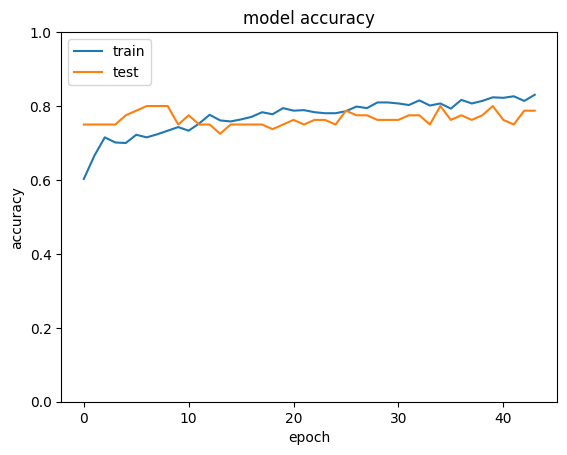

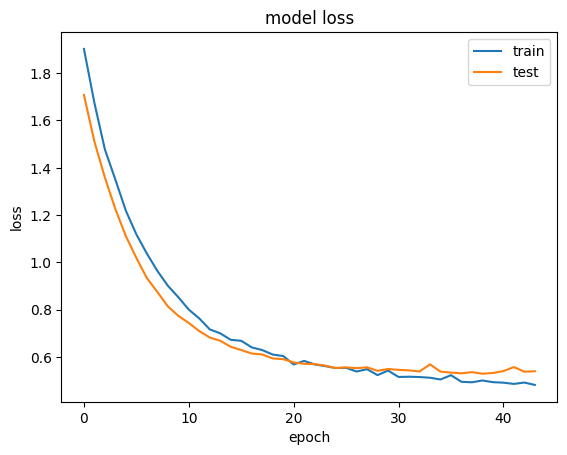

In [ ]:
# To summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0,1])
plt.show()


# To summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

In [ ]:
### Hyperparameter tuning:

In [ ]:

# Define a simple CNN model
def build_model(filters, kernel_size, learning_rate):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define hyperparameters grid
param_grid = {
    'filters': [32, 64],
    'kernel_size': [3, 5],
    'learning_rate': [0.01, 0.001]
}

# Sampling parameter configurations
param_list = list(ParameterSampler(param_grid, n_iter=10))
best_model = None
best_history = None




In [ ]:
# Manual search over the parameters
best_score = 0
best_params = {}
for params in param_list:
    model = build_model(**params)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model
        best_history = history



In [ ]:
print("Best Score:", best_score)
print("Best Params:", best_params)

Best Score: 0.7950000166893005
Best Params: {'learning_rate': 0.001, 'kernel_size': 3, 'filters': 32}


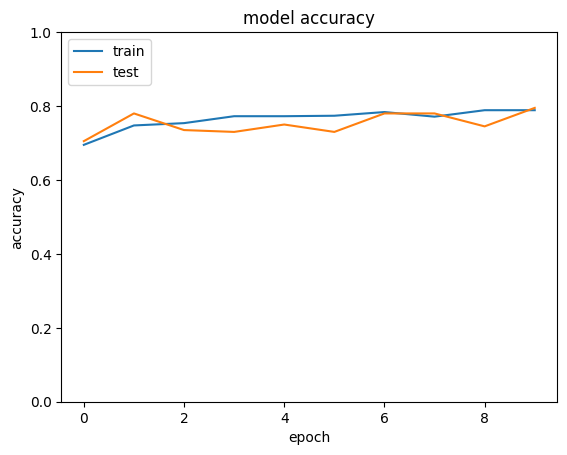

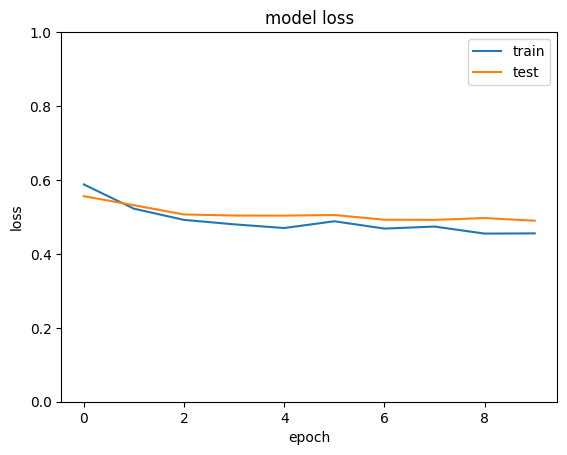

In [ ]:

plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0,1])
plt.show()


# To summarize history for loss
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim([0,1])

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Converts the probabilities to 0 or 1

# To Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


7/7 [==============================] - 0s 7ms/step


In [ ]:

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.795
Precision: 0.8211920529801324
Recall: 0.8985507246376812
F1 Score: 0.8581314878892733
ROC AUC Score: 0.7315334268349696


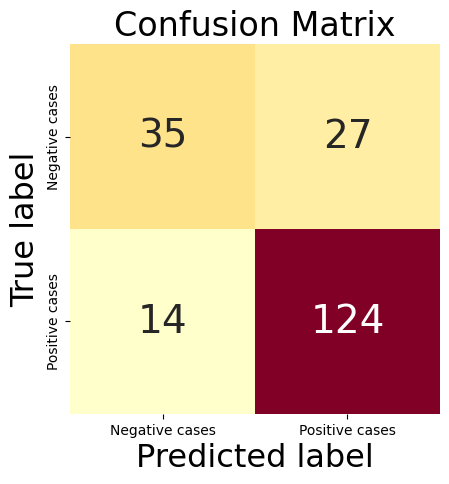

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative score', 'Positive score'],
            yticklabels=['Negative score', 'Positive score'],
            cmap='YlOrRd', annot_kws={"fontsize": 28})

plt.xlabel('Predicted label', fontsize=23)
plt.ylabel('True label', fontsize=23)
plt.title('Confusion Matrix', fontsize=24)

plt.show()

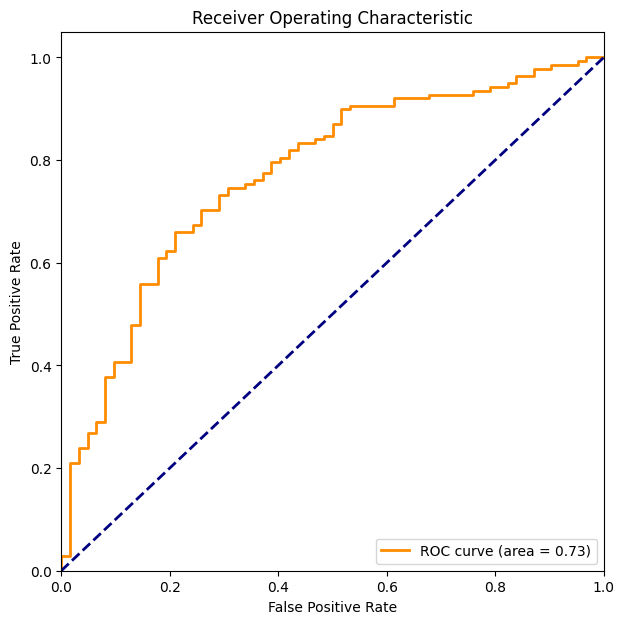

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

7/7 [==============================] - 0s 3ms/step
AUPRC: 0.8821212364484806


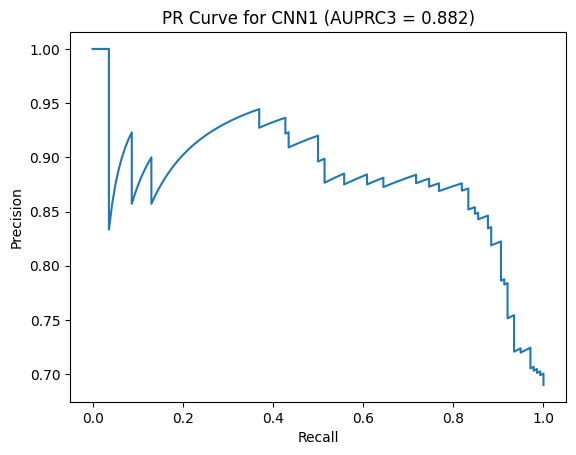

In [ ]:
# Predicted probabilities for positive class
y_scores = best_model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# To calculate area under the PRC
auprc3 = average_precision_score(y_test, y_scores)
print('AUPRC:', auprc3)

# Plot the PR curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for CNN1 (AUPRC3 = {:.3f})'.format(auprc3))
plt.show()

1/1 [==============================] - 0s 40ms/step


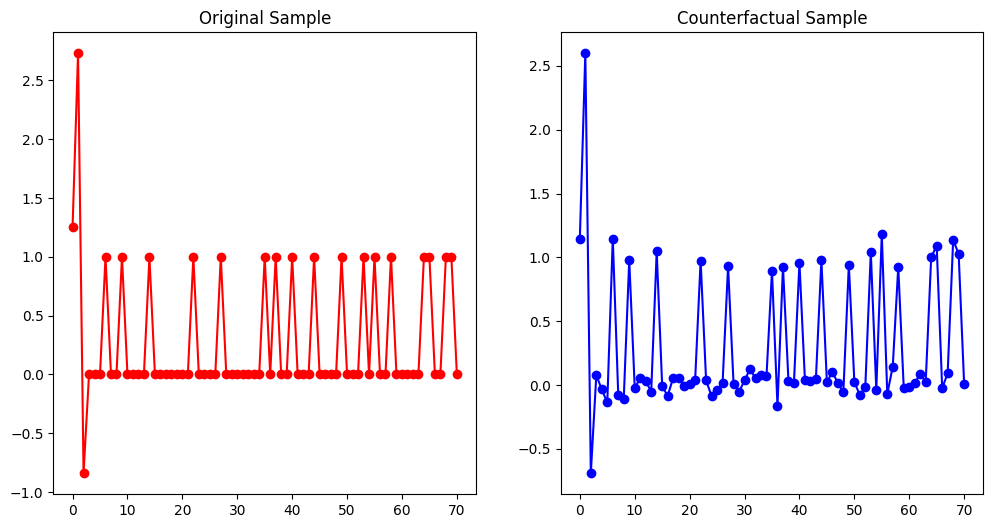

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_counterfactual(model, sample, target, max_iter=1000, learning_rate=0.01):
    original_sample = np.copy(sample)
    for i in range(max_iter):
        # Predict with current sample
        pred = model.predict(sample.reshape(1, -1, 1))[0][0]

        # Check if the target is achieved
        if (pred > 0.5) == target:
            return sample

        # Calculates the gradient of the loss with respect to the input
        # slightly perturbing the input and observing changes in output
        perturbation = np.random.randn(*sample.shape) * learning_rate
        new_sample = sample + perturbation
        new_pred = model.predict(new_sample.reshape(1, -1, 1))[0][0]


        if abs(new_pred - target) < abs(pred - target):
            sample = new_sample  # Accept the new sample if it's closer to the target

    return original_sample  # Return original if no counterfactual found within max_iter

# Example usage
sample = X_test[0]  # Assuming X_test is scaled and reshaped appropriately
target = not y_test[0]  # Trying to flip the original decision
counterfactual = find_counterfactual(best_model, sample, target)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Sample")
plt.plot(sample.flatten(), 'ro-')
plt.subplot(1, 2, 2)
plt.title("Counterfactual Sample")
plt.plot(counterfactual.flatten(), 'bo-')
plt.show()


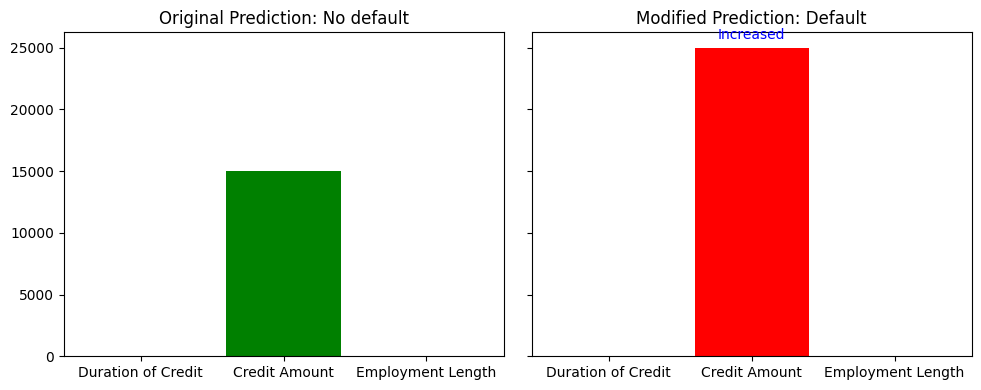

In [ ]:


# Define the feature values for the two instances
features = ['Duration of Credit', 'Credit Amount', 'Employment Length']
original_values = [24, 15000, 5]
modified_values = [24, 25000, 5]

# Prediction outcomes
original_prediction = 'No default'
modified_prediction = 'Default'

# Create a bar chart for visual comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax[0].bar(features, original_values, color='green')
ax[0].set_title(f'Original Prediction: {original_prediction}')
ax[1].bar(features, modified_values, color='red')
ax[1].set_title(f'Modified Prediction: {modified_prediction}')

# Highlight changes
for i, (orig, mod) in enumerate(zip(original_values, modified_values)):
    if orig != mod:
        ax[1].text(i, mod + 500, 'Increased', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()


In [ ]:
# Fitting the scaler with the correct column names
scaler.fit(data[['Duration of Credit (month)', 'Credit Amount', 'Length of current employment']])

StandardScaler()

1/1 [==============================] - 0s 78ms/step
Original Prediction: Default
Modified Prediction: Default


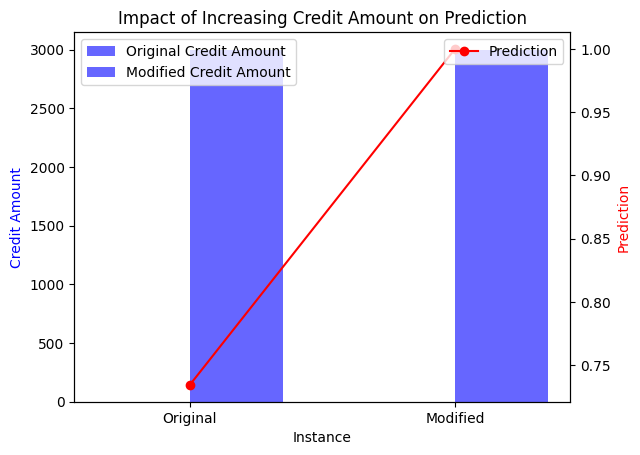

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure X_transformed is dense
X_transformed_dense = X_transformed.toarray()

np.random.seed(42)  # For reproducibility
random_index = np.random.randint(0, X_transformed_dense.shape[0])

# Select an instance and expand dimensions to match input shape required by the CNN
original_instance = X_transformed_dense[random_index].reshape(1, -1, 1)

# Copy the original instance to create a modified one
modified_instance = np.copy(original_instance)

# Manually increase the credit amount
credit_amount_index = 5  # This index needs to be correct based on your feature set
modified_instance[0, credit_amount_index, 0] += 3000  # Increase by $3000

# Predict the outcomes using the best_model
original_prediction = best_model.predict(original_instance)[0][0]
modified_prediction = best_model.predict(modified_instance)[0][0]

print("Original Prediction:", 'Default' if original_prediction >= 0.5 else 'No default')
print("Modified Prediction:", 'Default' if modified_prediction >= 0.5 else 'No default')

# Visualization
features = ['Credit Amount']  # Assuming this is the feature we're focusing on
original_values = [original_instance[0, credit_amount_index, 0]]
modified_values = [modified_instance[0, credit_amount_index, 0]]
predictions = [original_prediction, modified_prediction]

fig, ax1 = plt.subplots()


index = np.arange(2)

# Bar plot for Credit Amount
bar_width = 0.35
bars = ax1.bar(index, original_values * 2, bar_width, label='Original Credit Amount', color='blue', alpha=0.6)  # Multiplies by 2 to match the length of index
bars2 = ax1.bar(index + bar_width, modified_values * 2, bar_width, label='Modified Credit Amount', color='blue', alpha=0.6)  # Multiplied by 2 to match the length of index
ax1.set_xlabel('Instance')
ax1.set_ylabel('Credit Amount', color='blue')
ax1.set_title('Impact of Increasing Credit Amount on Prediction')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(['Original', 'Modified'])
ax1.legend(loc='upper left')

# Plot for Predictions
ax2 = ax1.twinx()
ax2.plot(index + bar_width / 2, predictions, marker='o', color='red', label='Prediction')
ax2.set_ylabel('Prediction', color='red')
ax2.legend(loc='upper right')

plt.show()


In [ ]:
### Model 3: Convolutional Neural Networks with SMOTE

In [ ]:
X = preprocessor.fit_transform(data.drop('Creditability', axis=1))

In [ ]:
X

<1000x71 sparse matrix of type '<class 'numpy.float64'>'
	with 20000 stored elements in Compressed Sparse Row format>

In [ ]:
# Instantiating SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# To Count the number of occurrences of each class after resampling
counter = Counter(y_resampled)
print("Resampled target variable distribution:", counter)

Resampled target variable distribution: Counter({1: 700, 0: 700})


In [ ]:
y_resampled.shape

(1400,)

In [ ]:
# Splitting the data using 80% for training and 20% for test

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)



In [ ]:
# Converting from sparse to dense format, then reshape the sets
X_train = X_train.toarray().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.toarray().reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Defining the 1D CNN model architecture
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.55),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assigned'1' because it is a binary classification problem
])



In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Setting early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


In [ ]:
# To train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
32/32 [==============================] - 3s 27ms/step - loss: 0.6898 - accuracy: 0.5476 - val_loss: 0.6644 - val_accuracy: 0.5625
Epoch 2/50
32/32 [==============================] - 1s 18ms/step - loss: 0.6384 - accuracy: 0.6498 - val_loss: 0.5512 - val_accuracy: 0.7500
Epoch 3/50
32/32 [==============================] - 1s 19ms/step - loss: 0.5729 - accuracy: 0.7063 - val_loss: 0.4911 - val_accuracy: 0.7500
Epoch 4/50
32/32 [==============================] - 1s 17ms/step - loss: 0.5560 - accuracy: 0.7282 - val_loss: 0.4809 - val_accuracy: 0.7589
Epoch 5/50
32/32 [==============================] - 1s 19ms/step - loss: 0.5297 - accuracy: 0.7421 - val_loss: 0.4945 - val_accuracy: 0.7232
Epoch 6/50
32/32 [==============================] - 1s 27ms/step - loss: 0.5251 - accuracy: 0.7252 - val_loss: 0.4716 - val_accuracy: 0.7589
Epoch 7/50
32/32 [==============================] - 1s 25ms/step - loss: 0.5123 - accuracy: 0.7679 - val_loss: 0.4700 - val_accuracy: 0.7768
Epoch 8/50
32

In [ ]:
# To evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

9/9 [==============================] - 0s 10ms/step - loss: 0.5011 - accuracy: 0.7750
Test Loss: 0.5011050701141357, Test Accuracy: 0.7749999761581421


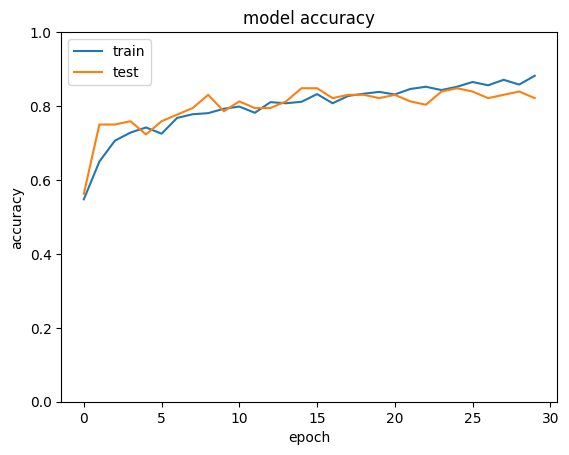

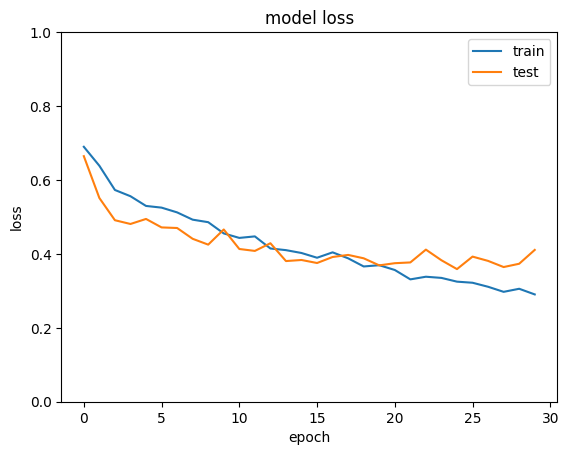

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim([0, 1])
plt.show()


In [ ]:
# Computing the Performance metrics
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

9/9 [==============================] - 0s 9ms/step
Accuracy: 0.775
Precision: 0.8608695652173913
Recall: 0.678082191780822
F1 Score: 0.7586206896551724
ROC AUC Score: 0.7793396033530975


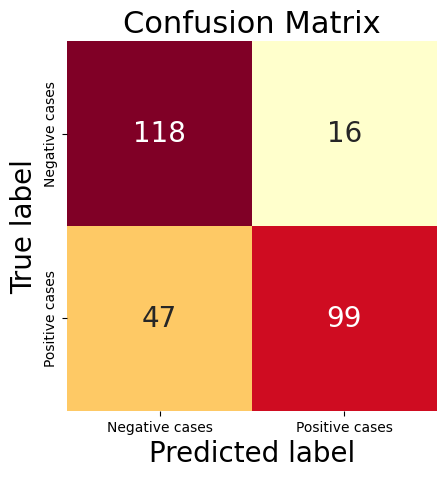

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative cases', 'Positive cases'],
            yticklabels=['Negative cases', 'Positive cases'],
            cmap='YlOrRd', annot_kws={"fontsize": 20})

plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.title('Confusion Matrix', fontsize=22)

plt.show()

In [ ]:

# Using y_pred and y_test from the model predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# To Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

9/9 [==============================] - 0s 8ms/step
Accuracy: 0.775
Precision: 0.8608695652173913
Recall: 0.678082191780822
F1 Score: 0.7586206896551724
ROC AUC Score: 0.7793396033530975


In [ ]:
# Hyperparameter tuning of the CNN2 Model

In [ ]:

def build_model(hp):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.05)),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.05)),
        Dense(units=64, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
#Setting the keras tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='new_tuner_directory1',
    project_name='new_hyperband_project1'
)

In [ ]:
# Searching for the hyperparameters
history = tuner.search(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])




Trial 30 Complete [00h 00m 13s]
val_accuracy: 0.8035714030265808

Best val_accuracy So Far: 0.8482142686843872
Total elapsed time: 00h 03m 22s


In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


9/9 [==============================] - 0s 6ms/step - loss: 0.4332 - accuracy: 0.7821
Test Loss: 0.4331652522087097, Test Accuracy: 0.7821428775787354


In [ ]:
print(tuner.results_summary())

Results summary
Results in new_tuner_directory1/new_hyperband_project1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0027 summary
Hyperparameters:
dropout_1: 0.35000000000000003
dropout_2: 0.5
learning_rate: 0.00657272735163442
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8482142686843872

Trial 0016 summary
Hyperparameters:
dropout_1: 0.2
dropout_2: 0.45
learning_rate: 0.0011754146074556676
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.8214285969734192

Trial 0024 summary
Hyperparameters:
dropout_1: 0.45
dropout_2: 0.4
learning_rate: 0.0006029308510873298
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.8214285969734192

Trial 0025 summary
Hyperparameters:
dropout_1: 0.2
dropout_2: 0.6000000000000001
learning_rate: 0.002162662438641237
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tune

In [ ]:

#Computing the metrics
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

9/9 [==============================] - 0s 5ms/step
Accuracy: 0.7821428571428571
Precision: 0.7972027972027972
Recall: 0.7808219178082192
F1 Score: 0.7889273356401385
ROC AUC Score: 0.7822020036802291


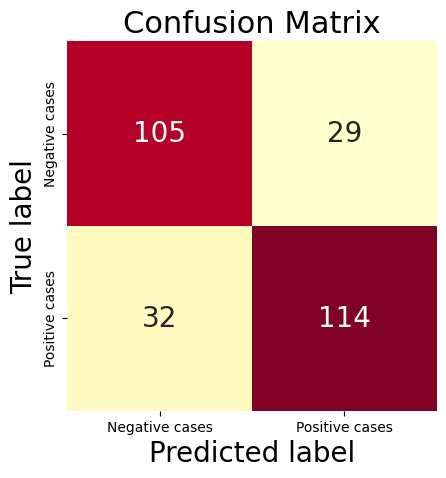

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative cases', 'Positive cases'],
            yticklabels=['Negative cases', 'Positive cases'],
            cmap='YlOrRd', annot_kws={"fontsize": 20})

plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.title('Confusion Matrix', fontsize=22)

plt.show()

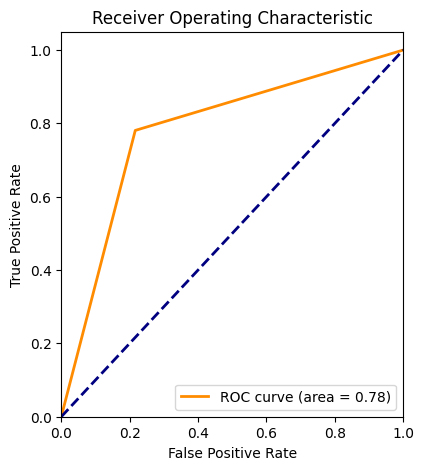

In [ ]:
# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


9/9 [==============================] - 0s 11ms/step
AUPRC: 0.8959285156023802


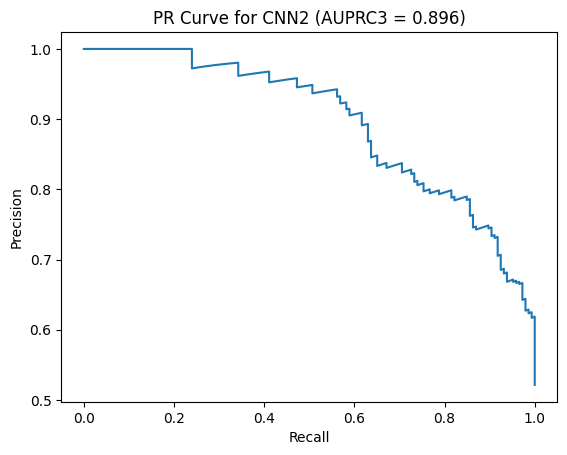

In [ ]:
# Get predicted probabilities for positive class
y_scores = best_model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# To calculate area under the PRC
auprc3 = average_precision_score(y_test, y_scores)
print('AUPRC:', auprc3)

# Plot the PR curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for CNN2 (AUPRC3 = {:.3f})'.format(auprc3))
plt.show()

In [ ]:
#Counterfactual explanation

In [ ]:
original_numerical_df

Duration of Credit (month)  Credit Amount  Age (years)
0                        24.0         6615.0         75.0

In [ ]:
# Find an instance in the test set where the model predicts "not creditworthy"
instance_index = None
for i in range(len(X_test)):
    if best_model.predict(X_test[i].reshape(1, -1, 1))[0][0] < 0.5:
        instance_index = i
        break

if instance_index is not None:
    instance = X_test[instance_index].reshape(1, -1, 1)
    original_prediction = best_model.predict(instance)

1/1 [==============================] - 0s 42ms/step


In [ ]:
# Define a function to generate counterfactuals with constraints
def generate_counterfactual(instance, model, max_iter=1000, step=0.1):
    counterfactual = instance.copy()
    target_prediction = 1 - model.predict(instance)[0][0]  # Flip the prediction

    for _ in range(max_iter):
        prediction = model.predict(counterfactual)[0][0]
        if (prediction >= 0.5 and target_prediction == 1) or (prediction < 0.5 and target_prediction == 0):
            break

        # Gradually perturb the numerical features by a larger step
        perturbation = np.zeros_like(counterfactual)
        perturbation_direction = np.sign(target_prediction - prediction)
        perturbation[:, :len(numerical_features), 0] = perturbation_direction * step

        # Randomly perturb categorical features within valid ranges
        for i in range(len(numerical_features), counterfactual.shape[1]):
            counterfactual[:, i, 0] = np.random.choice([0, 1, 2, 3, 4])  # Assuming each categorical feature has 5 categories

        counterfactual += perturbation

        # Ensure non-negative values and clamp to realistic ranges
        counterfactual[:, 0, 0] = np.clip(counterfactual[:, 0, 0], 0, 60)  # Duration of Credit (0 to 60 months)
        counterfactual[:, 1, 0] = np.clip(counterfactual[:, 1, 0], 0, 20000)  # Credit Amount (0 to 20,000)
        counterfactual[:, 2, 0] = np.clip(counterfactual[:, 2, 0], 18, 100)  # Age (18 to 100 years)
    return counterfactual

1/1 [==============================] - 0s 44ms/step
Original Prediction: [[0.23625843]]
Counterfactual Prediction: [[0.8830573]]


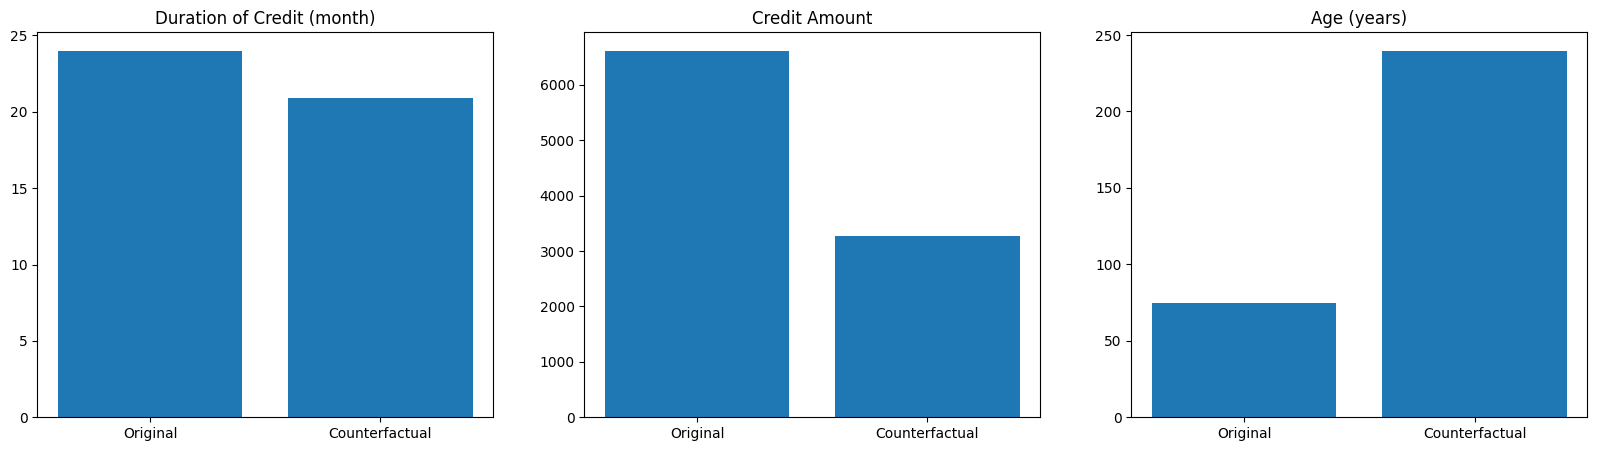

In [ ]:


# Generate a counterfactual explanation
counterfactual = generate_counterfactual(instance, best_model)
counterfactual_prediction = best_model.predict(counterfactual)

# Print the original and counterfactual predictions
print("Original Prediction:", original_prediction)
print("Counterfactual Prediction:", counterfactual_prediction)

# Reverse the preprocessing to get the interpretable features
instance_flat = instance.reshape(1, -1)
counterfactual_flat = counterfactual.reshape(1, -1)

# Inverse transform for numerical features
numerical_inverse = preprocessor.named_transformers_['num'].inverse_transform(instance_flat[:, :len(numerical_features)])
counterfactual_numerical = preprocessor.named_transformers_['num'].inverse_transform(counterfactual_flat[:, :len(numerical_features)])

# Inverse transform for categorical features
categorical_inverse = preprocessor.named_transformers_['cat'].inverse_transform(instance_flat[:, len(numerical_features):])
counterfactual_categorical = preprocessor.named_transformers_['cat'].inverse_transform(counterfactual_flat[:, len(numerical_features):])

# Combine the inverse transformed features
original_instance_features = np.concatenate((numerical_inverse, categorical_inverse), axis=1)
counterfactual_features = np.concatenate((counterfactual_numerical, counterfactual_categorical), axis=1)

# Create DataFrames for easier visualization
original_numerical_df = pd.DataFrame(numerical_inverse, columns=numerical_features)
counterfactual_numerical_df = pd.DataFrame(counterfactual_numerical, columns=numerical_features)

# Plotting numerical features
fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 5))
for i, feature in enumerate(numerical_features):
    axes[i].bar(['Original', 'Counterfactual'], [original_numerical_df[feature][0], counterfactual_numerical_df[feature][0]])
    axes[i].set_title(feature)
plt.show()

# Create a DataFrame for categorical features comparison
categorical_comparison_df = pd.DataFrame({
    'Feature': categorical_features,
    'Original': categorical_inverse[0],
    'Counterfactual': counterfactual_categorical[0]
})




In [ ]:
print("Original Numerical Features:\n", original_numerical_df)
print("Counterfactual Numerical Features:\n", counterfactual_numerical_df)


Original Numerical Features:
    Duration of Credit (month)  Credit Amount  Age (years)
0                        24.0         6615.0         75.0
Counterfactual Numerical Features:
    Duration of Credit (month)  Credit Amount  Age (years)
0                      20.903       3271.248   239.787863


In [ ]:
original_numerical_df

Duration of Credit (month)  Credit Amount  Age (years)
0                        24.0         6615.0         75.0

In [ ]:
counterfactual_numerical_df

Duration of Credit (month)  Credit Amount  Age (years)
0                      20.903       3271.248   239.787863

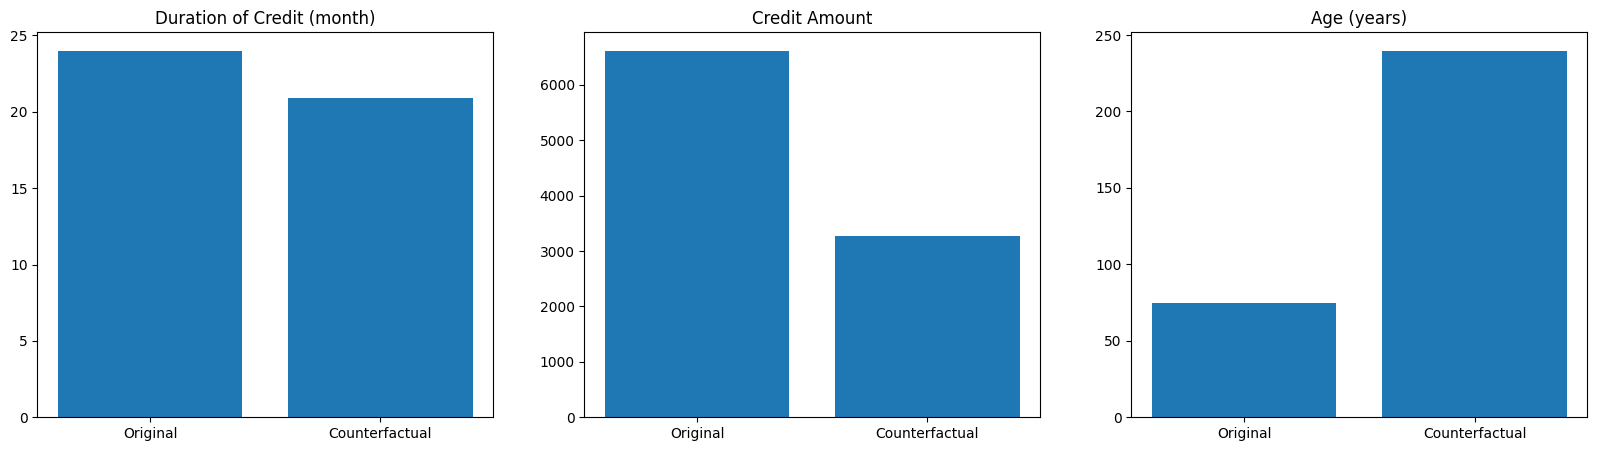

In [ ]:
# Plotting numerical features
fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 5))
for i, feature in enumerate(numerical_features):
    axes[i].bar(['Original', 'Counterfactual'], [original_numerical_df[feature][0], counterfactual_numerical_df[feature][0]])
    axes[i].set_title(feature)
plt.show()


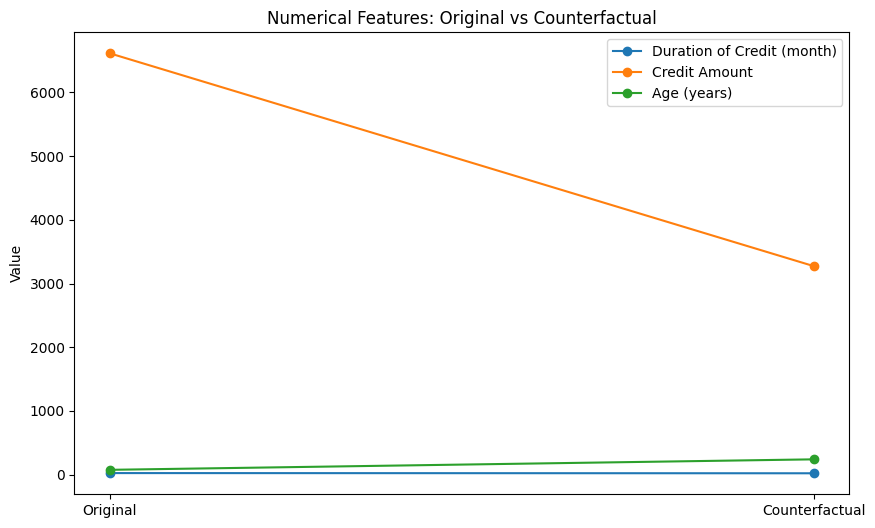

In [ ]:

# Create a line plot for numerical features
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each numerical feature
for feature in numerical_features:
    ax.plot(['Original', 'Counterfactual'], [original_numerical_df[feature][0], counterfactual_numerical_df[feature][0]], marker='o', label=feature)

# Set plot title and labels
ax.set_title('Numerical Features: Original vs Counterfactual')
ax.set_ylabel('Value')
ax.legend()
plt.show()


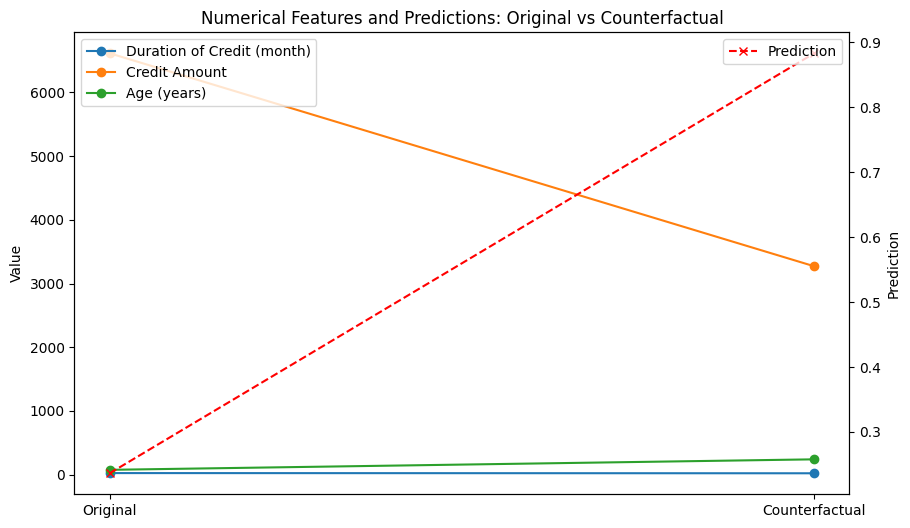

In [ ]:
# Create a line plot for numerical features
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot each numerical feature
for feature in numerical_features:
    ax1.plot(['Original', 'Counterfactual'], [original_numerical_df[feature][0], counterfactual_numerical_df[feature][0]], marker='o', label=feature)

# Add predictions to the plot
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.plot(['Original', 'Counterfactual'], [original_prediction[0][0], counterfactual_prediction[0][0]], marker='x', color='r', linestyle='--', label='Prediction')
ax2.set_ylabel('Prediction')

# Set plot title and labels
ax1.set_title('Numerical Features and Predictions: Original vs Counterfactual')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


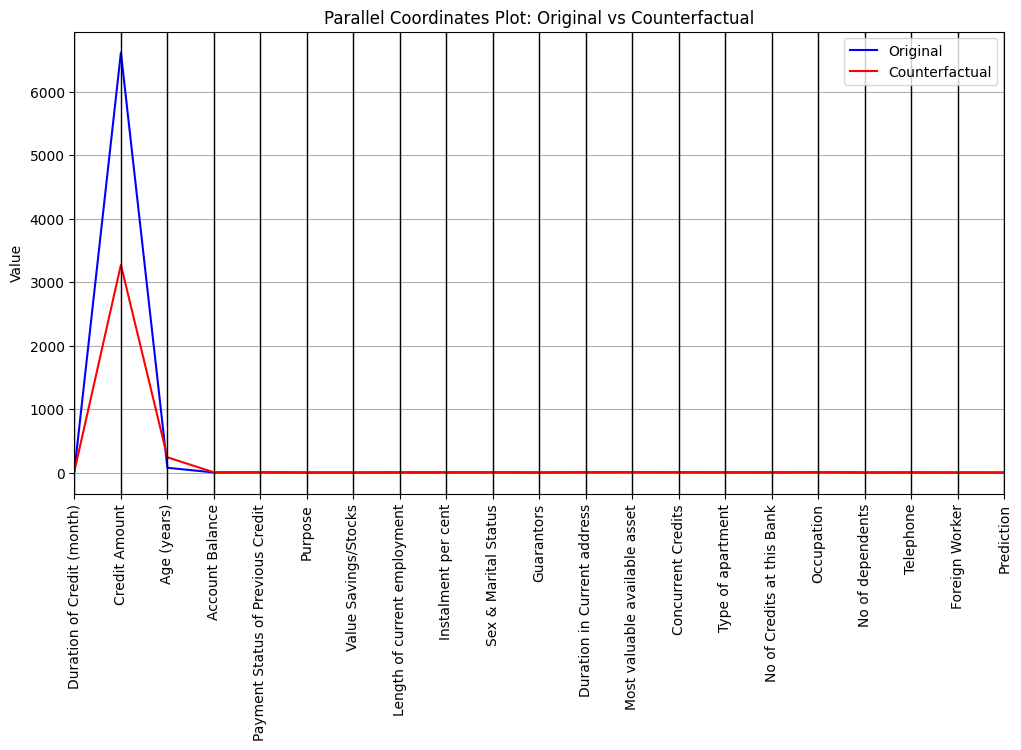

In [ ]:

# Combine features and predictions into a DataFrame
combined_df = pd.DataFrame(np.concatenate((original_instance_features, counterfactual_features), axis=0), columns=numerical_features + categorical_features)
combined_df['Prediction'] = [original_prediction[0][0], counterfactual_prediction[0][0]]
combined_df['Instance'] = ['Original', 'Counterfactual']

# Plot parallel coordinates
plt.figure(figsize=(12, 6))
parallel_coordinates(combined_df, 'Instance', color=['blue', 'red'])
plt.title('Parallel Coordinates Plot: Original vs Counterfactual')
plt.ylabel('Value')
plt.xticks(rotation=90)  # Rotate xticks to horizontal
plt.show()


In [ ]:

# Convert the sparse arrays to dense arrays if needed and flatten them
X_resampled_dense = X_resampled if isinstance(X_resampled, np.ndarray) else X_resampled.toarray()
X_test_dense = X_test if isinstance(X_test, np.ndarray) else X_test.toarray()

# Flatten the arrays to make them two-dimensional
X_resampled_flat = X_resampled_dense.reshape(X_resampled_dense.shape[0], -1)
X_test_flat = X_test_dense.reshape(X_test_dense.shape[0], -1)



In [ ]:
# Create a function to wrap the Keras model and reshape input data
def model_predict(data):
    data_reshaped = data.reshape(data.shape[0], -1, 1)  # Adjust the shape as expected by the model
    return best_model.predict(data_reshaped).flatten()




In [ ]:
# Use shap.sample to summarize the background data to avoid slow runtimes
background_data = shap.sample(X_resampled_flat, 100)



In [ ]:
# Initialize SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(model_predict, background_data)



4/4 [==============================] - 0s 6ms/step


In [ ]:
# Calculate SHAP values
shap_values = explainer.shap_values(X_test_flat, nsamples=100)



  0%|          | 0/280 [00:00<?, ?it/s]

313/313 [==============================] - 3s 8ms/step


In [ ]:
# Combine feature names
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))



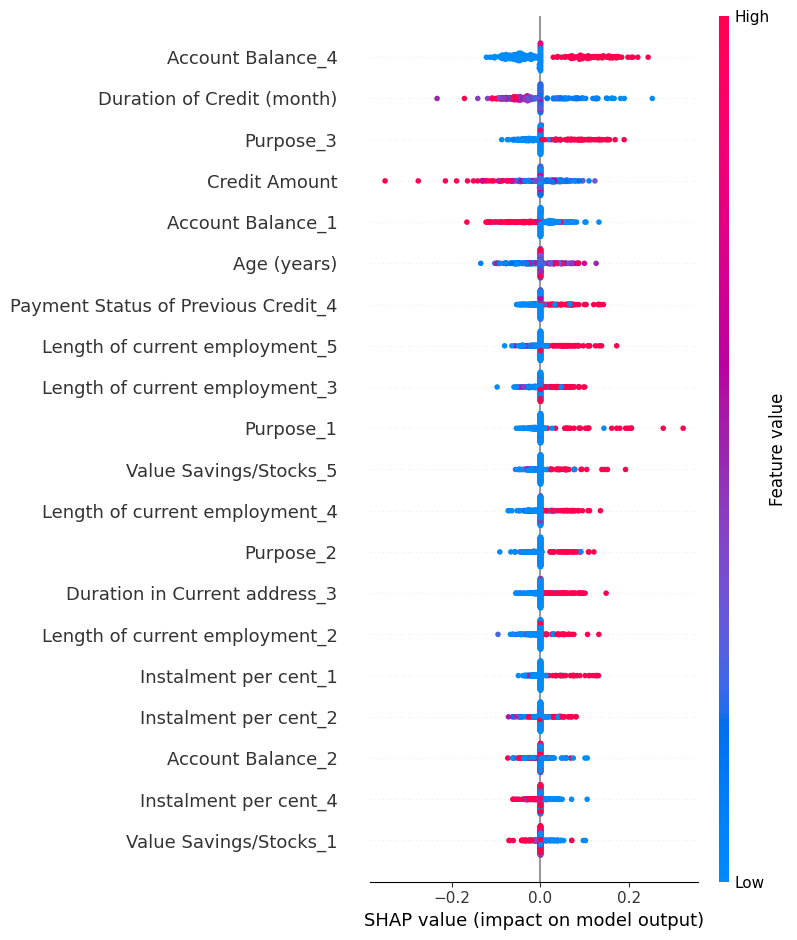

In [ ]:
# Create a summary plot
shap.summary_plot(shap_values, X_test_flat, feature_names=feature_names)



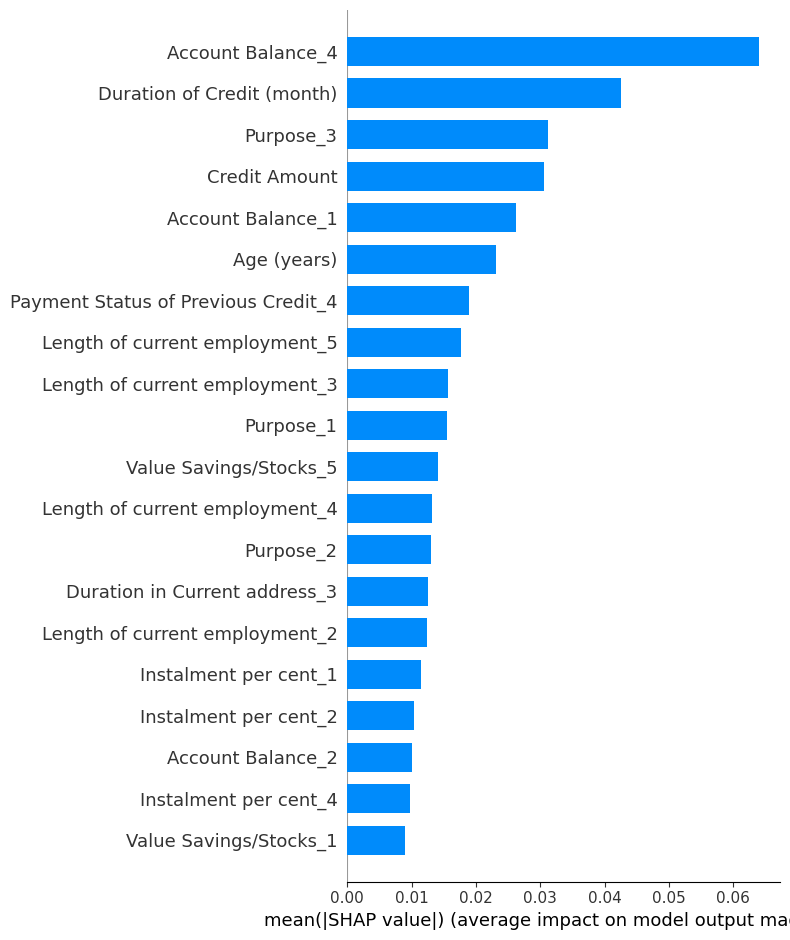

In [ ]:
# Create a bar plot for global feature importance
shap.summary_plot(shap_values, X_test_flat, plot_type="bar", feature_names=feature_names)